# **Initial Analysis of the PN Data**

- - - -

### Table of Contents

* [1. Initialisation](#initialisation)
    * [1.1 HEASOFT](#HEASOFT)
    * [1.2 SAS](#sas)
* [2. Importing the ODF](#ODF)
    * [2.1 Python Script](#section_2_1)
    * [2.2 Defining the path directions](#section_2_2)
* [3. Creating Image](#image)
* [4. Filtering the Data](#filter)   
    * [4.1 Lightcurve](#lightcurve)
* [5. Source Detection](#source)   
* [6. Checking for Pileup](#pileup)
* [7. Preparing the Spectrum](#specprepare)
* [8. XSPEC](#xspec)
    * [8.1 Fitting a Model](#model)
    * [8.2 Creating the Unfolded Spectrum](#unfolded)
* [9. Background Lightcurve](#bck_light)
* [10. Fitting a Model](#model)
    * [10.2 Kerrdisk + 2 gaussians](#kerrdisk_ext)

- - - -

In [2]:
from IPython.display import Image

### 1. Initialisation<a class="anchor" id="initialisation"></a>

#### 1.1 HEASOFT <a class="anchor" id="HEASOFT"></a>
To install and initialise HEASOFT, the following was entered into the `.bashrc` file:

In [ ]:
source scl_source enable devtoolset-7
export HEADAS=/usr/local/heasoft-6.28/x86_64-pc-linux-gnu-libc2.17
alias heainit=". $HEADAS/headas-init.sh"

This can then be initialised using the alias `heainit` whenever a new session is created

#### 1.2 SAS<a class="anchor" id="sas"></a>
To install and initialise SAS, the following was entered into the `.bashrc` file:

In [ ]:
export SAS_DIR=/usr/local/xmm_sas/xmmsas_20210317_1624
alias sasinit=". $SAS_DIR/sas-setup.sh"
export SAS_CCFPATH=/usr/local/XMM/ccf/
export SAS_CCF=/data/cluster4/jamie_and_jeton/xmm_obs/ccf.cif

This can then be initialised using the alias `sasinit` whenever a new session is created

### 2 Importing the ODF<a class="anchor" id="ODF"></a>
Initially the ODF was imported into the working directory in the shared file using startsas. Following section **Executing Startsas** at https://www.cosmos.esa.int/web/xmm-newton/sas-thread-startup-in-python
To do this, a python script was made which uses and *odfid* to import the ODF into a selected destination.

#### 2.1 Python Script <a class="anchor" id="section_2_1"></a>

In [ ]:
import os
from pysas.wrapper import Wrapper as w
work_dir = '/data/cluster4/jamie_and_jeton/work_dir/0301_0029740101_data'
inargs = [f'odfid=0029740101',f'workdir={work_dir}']
w('startsas', inargs).run()

**<span style="color:red">
For analysis of different ODFs, a different odfid and destination path will need to be defined before startsas is ran otherwise this will overwrite data!</span>**

#### 2.2 Defining the path directions <a class="anchor" id="section_2_2"></a>

In [ ]:
export SAS_CCF='/data/cluster4/jamie_and_jeton/work_dir/'

In [ ]:
odfingest

In [ ]:
export SAS_ODF='/data/cluster4/jamie_and_jeton/work_dir/0301_0029740101_data/0301_0029740101_SCX00000SUM.SAS'

### 3. Creating Image<a class="anchor" id="image"></a>

To get a sense of what the data we are using looks like and comes from, an image of the source is made. 1st epproc is ran.

In [ ]:
epproc

Imaging events file renamed to `EPIC.fits`

In [ ]:
evselect table=EPIC.fits withimageset=yes imageset=image.fits xcolumn=X ycolumn=Y imagebinning=imageSize ximagesize=600 yimagesize=600

In [ ]:
ds9 image.fits &


<img src="Figures/MCG-6-30-15_Source_Image.png"/>
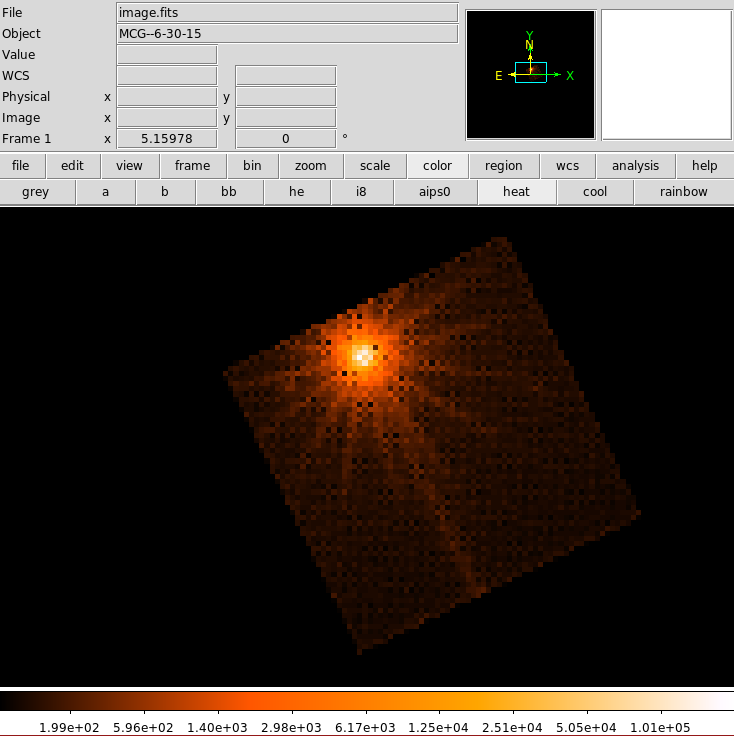

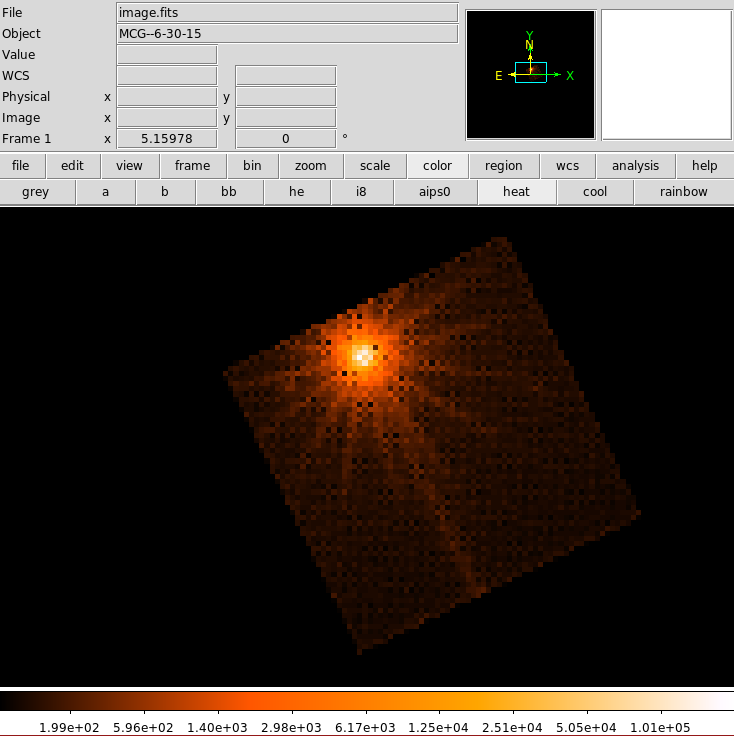

In [4]:
Image(filename="Figures/MCG-6-30-15_Source_Image.png")

The scale was set to **log** and the colour to **heat**.

### 4 Filtering the Data <a class="anchor" id="Filter"></a>
#### 4.1 Standard filters<a class="anchor" id="std filt"></a>

In [ ]:
evselect table=EPIC.fits withfilteredset=yes expression='(PATTERN <= 4)&&(PI in [200:15000])' filteredset=EPIC_filtered.fits filtertype=expression keepfilteroutput=yes updateexposure=yes filterexposure=yes

#### 4.2 Light curve<a class="anchor" id="lightcurve"></a>

Plotting a lightcurve using the filtered data:

In [ ]:
evselect table=EPIC_filtered.fits withrateset=yes rateset=lightcurve_filtered.fits maketimecolumn=yes timecolumn=TIME timebinsize=100 makeratecolumn=yes 

In [ ]:
dsplot table=lightcurve_filtered.fits x=TIME y=RATE   

<img src="Figures/MCG-6-30-15_filtered_light_curve.png"/>
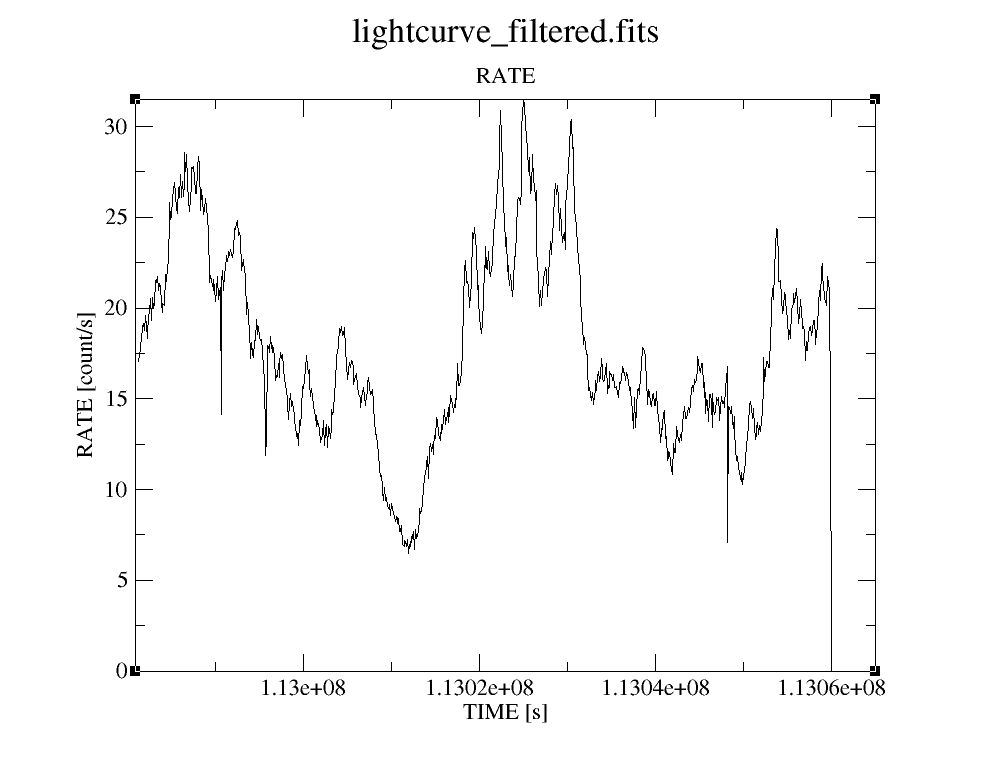

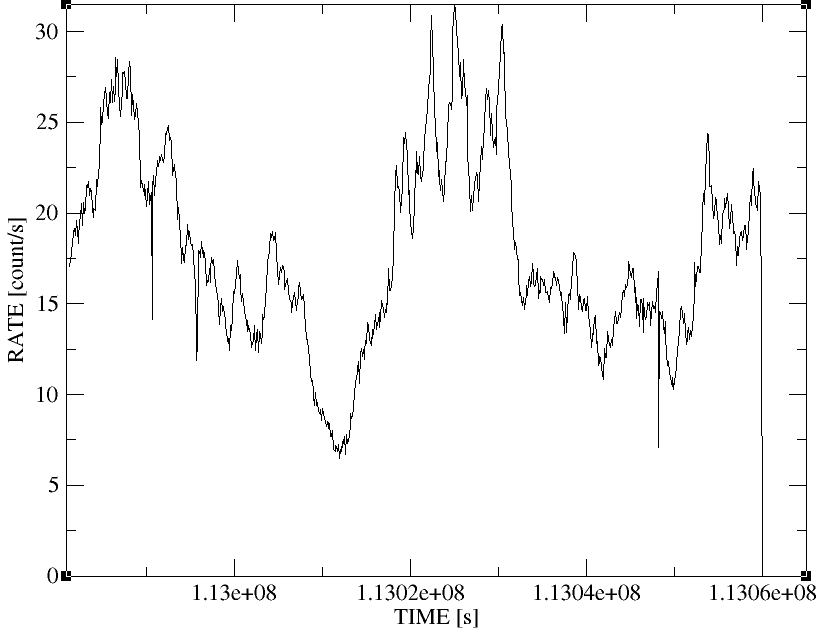

In [5]:
Image(filename="Figures/MCG-6-30-15_filtered_light_curve.png")

There is a clear cutoff of data at the right side of the graph indicating that there was a flaring event that was filtered out. For brevity, a lightcurve using the unfiltered data will be created.

In [ ]:
evselect table=EPIC.fits withrateset=yes rateset=lightcurve_un-filtered.fits maketimecolumn=yes timecolumn=TIME timebinsize=100 makeratecolumn=yes

In [ ]:
dsplot table=lightcurve_un-filtered.fits.fits x=TIME y=RATE   

<img src="Figures/MCG-6-30-15_un-filtered_light_curve.png"/>
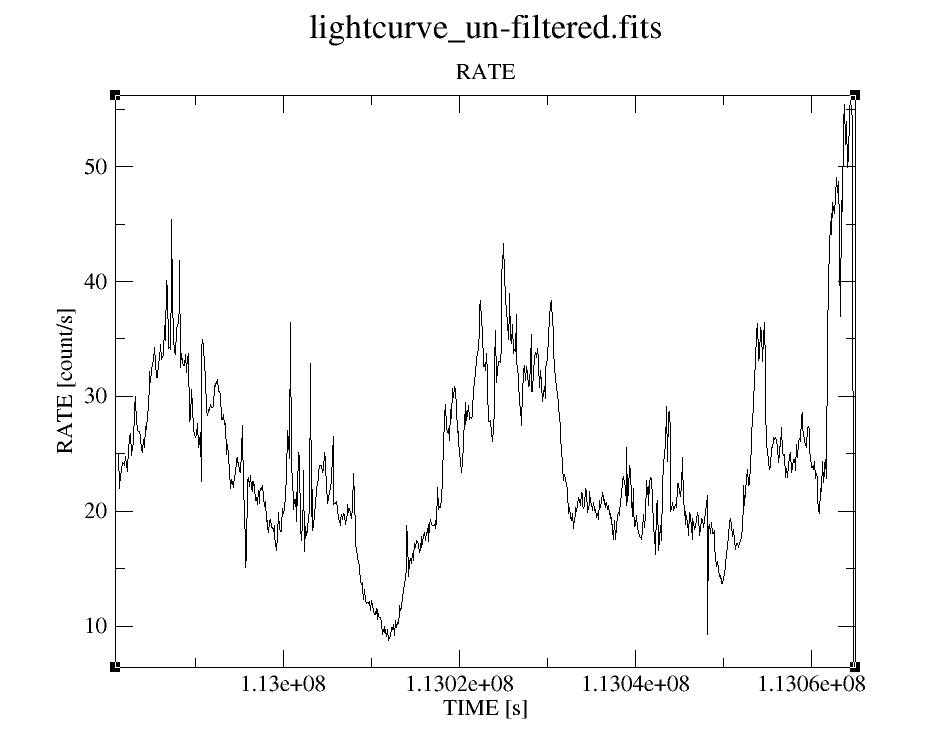

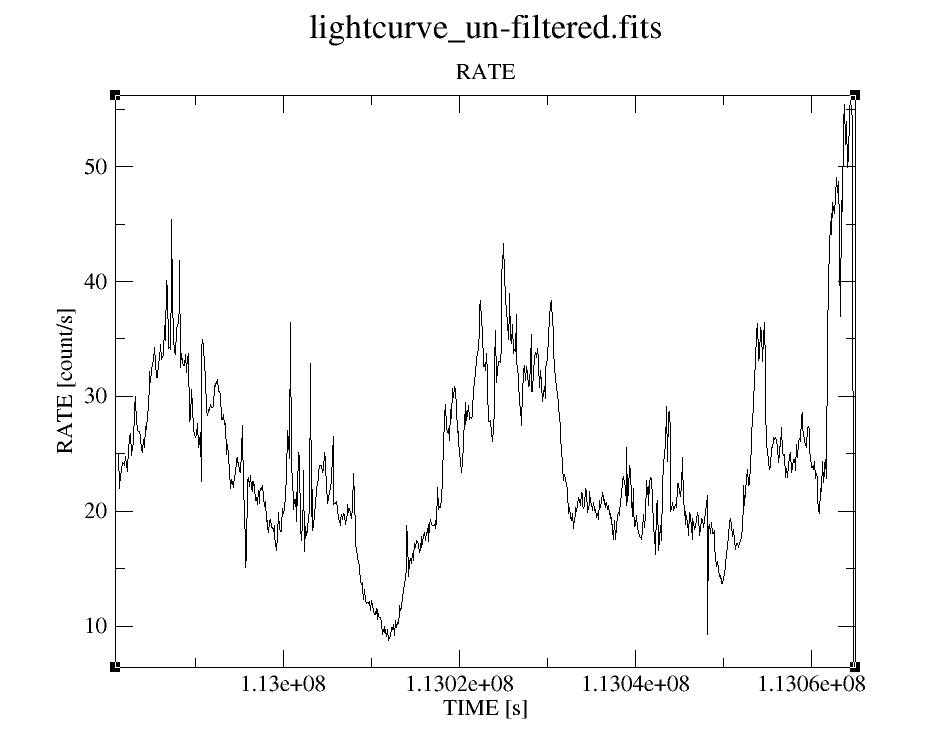

In [7]:
Image(filename="Figures/MCG-6-30-15_un-filtered_light_curve.png")

There is clearly a strong flaring event that should be removed. The standard filtering also removed various other counts from the un-filtered data that can be seen by comparing the two graphs. It is clear that the filtered data set should be used from here on.

#### 4.3 Deep Minimum Lightcurve <a class="anchor" id="source"></a>
To see how the data varies when the object is in a state of low flux, the data is restricted so that only counts taken between 1.13008x10$^{8}$ and 1.13015x10$^{8}$ are used.

In [ ]:
evselect table=EPIC_filtered.fits withfilteredset=yes filteredset=deepmin.fits filtertype=expression expression='(TIME < 1.13015e8)&&(TIME > 1.13008e8)' keepfilteroutput=yes updateexposure=yes

In [ ]:
evselect table=deepmin.fits withrateset=yes rateset=deepmin_lightcurve.fits maketimecolumn=yes timecolumn=TIME timebinsize=100 makeratecolumn=yes

In [ ]:
dsplot table=deepmin_lightcurve.fits x=TIME y=RATE

<img src="Figures/MCG-6-30-15_deepmin_light_curve.png"/>
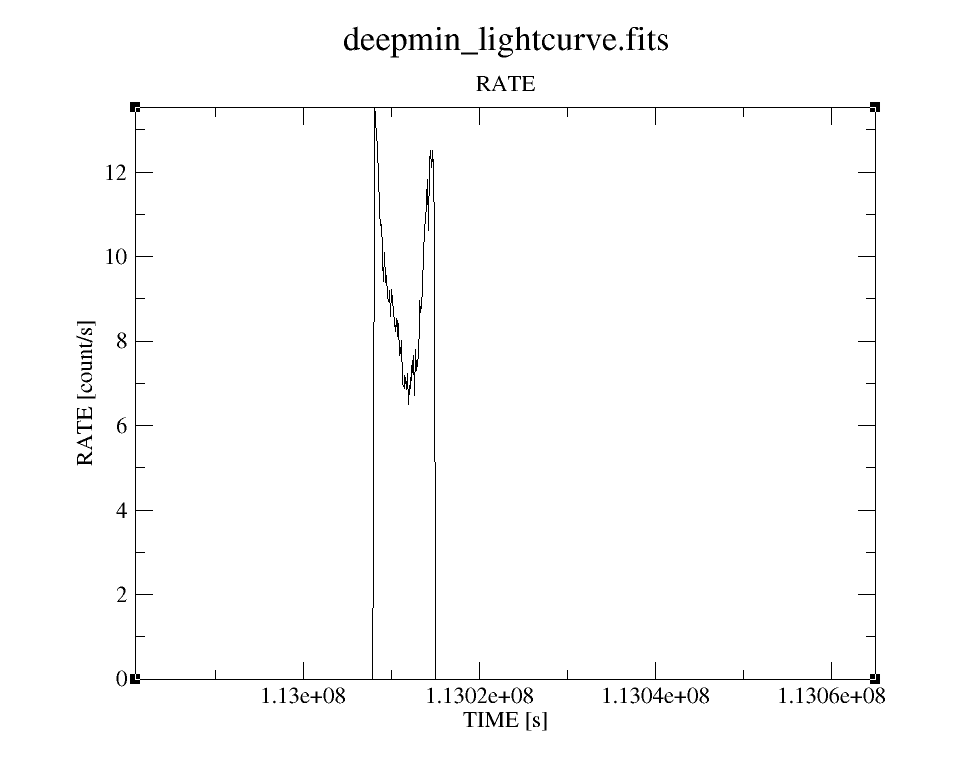

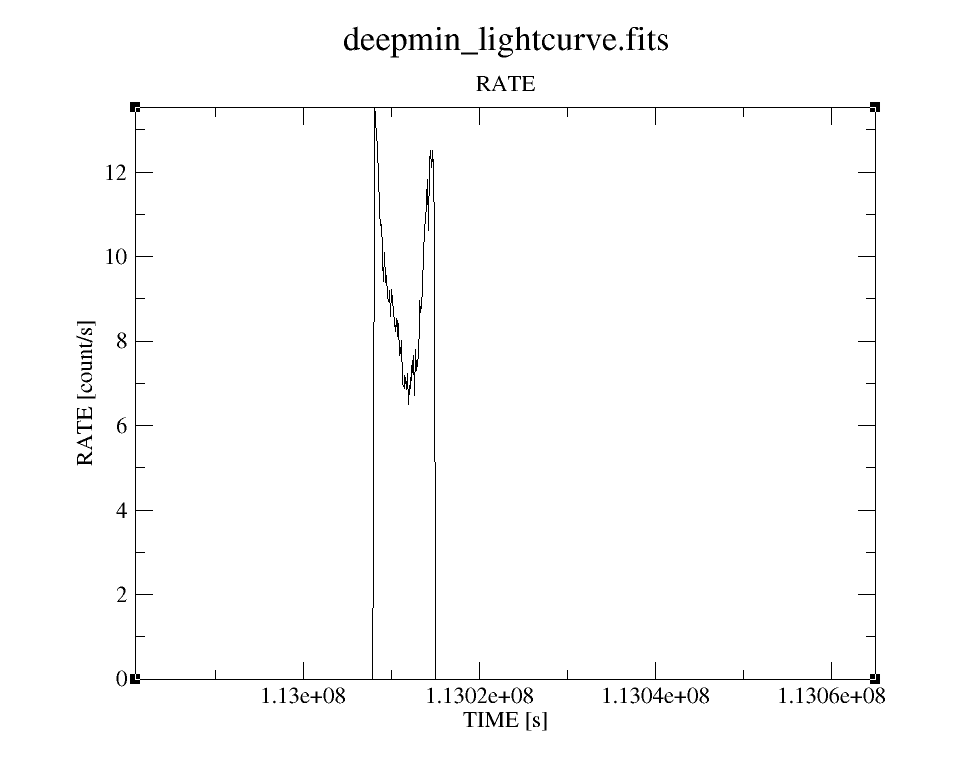

In [8]:
Image(filename="Figures/MCG-6-30-15_deepmin_light_curve.png")

### 5. Source Detection <a class="anchor" id="source"></a>

The image of the source was viewed again to determine where the source and background regions are. To do this it was viewed with ds9 and circles under the region tab were added to the image and altered in size until they matched these regions. The properties such as position and radius of these circles were set to physical units and recorded by using the regions "get information" option.

<img src="Figures/MCG-6-30-15_image_with_regions.png"/>
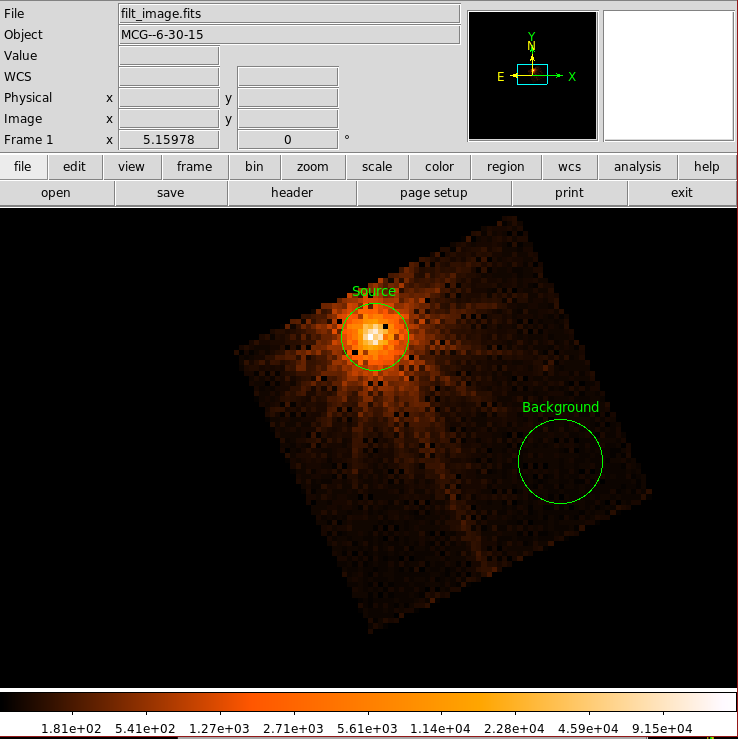

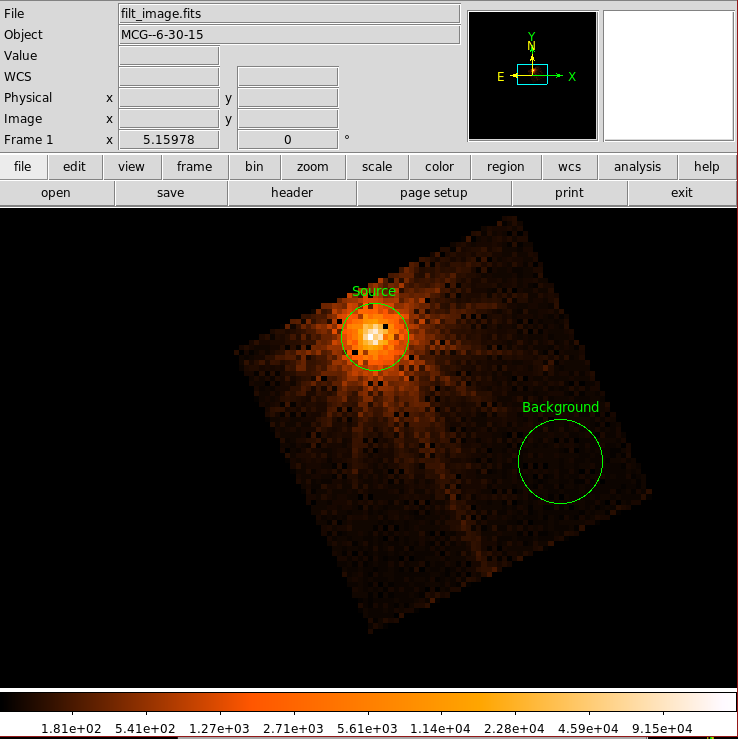

In [9]:
Image(filename="Figures/MCG-6-30-15_image_with_regions.png")

<img src="Figures/Background%20circle.png"/>
<img src="Figures/Source%20circle.png"/>
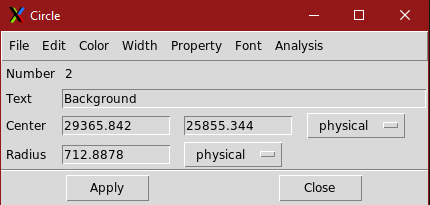
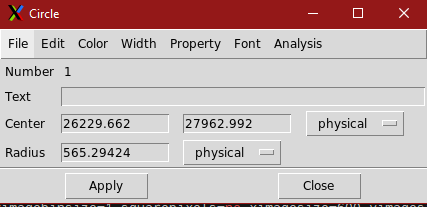

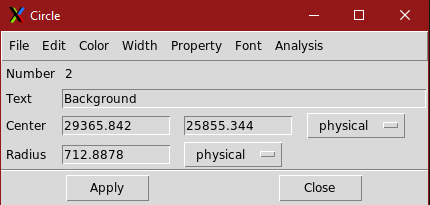

In [14]:
Image(filename="Figures/Background circle.png")


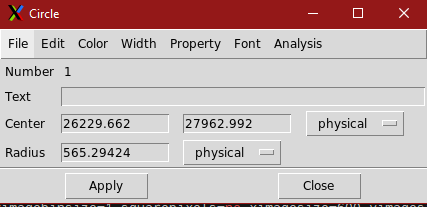

In [15]:
Image(filename="Figures/Source circle.png")

The spectrum of the source and background regions was then determined using `spectrumset`

In [ ]:
evselect table=EPIC_filt_time.fits withspectrumset=yes spectrumset=PNsource_spec.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression='(FLAG==0) && (PATTERN<=4) && ((X,Y) IN circle(26229.662,27962.992,565.3))'

In [ ]:
evselect table=EPIC_filt_time.fits withspectrumset=yes spectrumset=PNbackg_spec.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression='(FLAG==0) && (PATTERN<=4) && ((X,Y) IN circle(29365.842,25855.344,712.9))'

In [ ]:
backscale spectrumset=PNbackg_spec.fits badpixlocation=EPIC_filt_time.fits

### 6. Checking for Pileup<a class="anchor" id="pileup"></a>

In [ ]:
epatplot set=EPIC_filtered.fits plotfile=EPIC_epat.ps useplotfile=yes withbackgroundset=yes backgroundset=bkg_filtered.fits

The output of this is plotted with `gv`. There is an error raised stating<span style="color:red">Warning: Missing charsets in String to FontSet conversion</span>
This can be solved by issuing the command `export LC_CTYPE=C`. This is not a permanent solution as it resets so there may be something missing in solva.

In [ ]:
gv EPIC_epat.ps

<img src="Figures/MCG-6-30-15_Pileup.png"/>
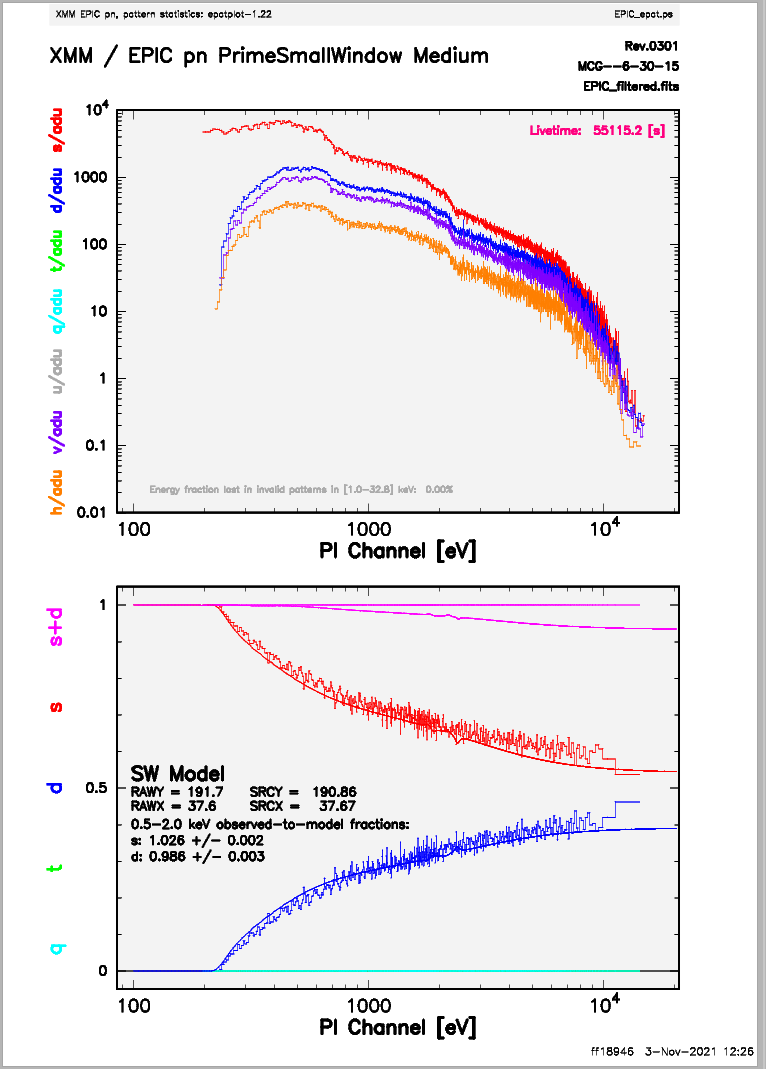

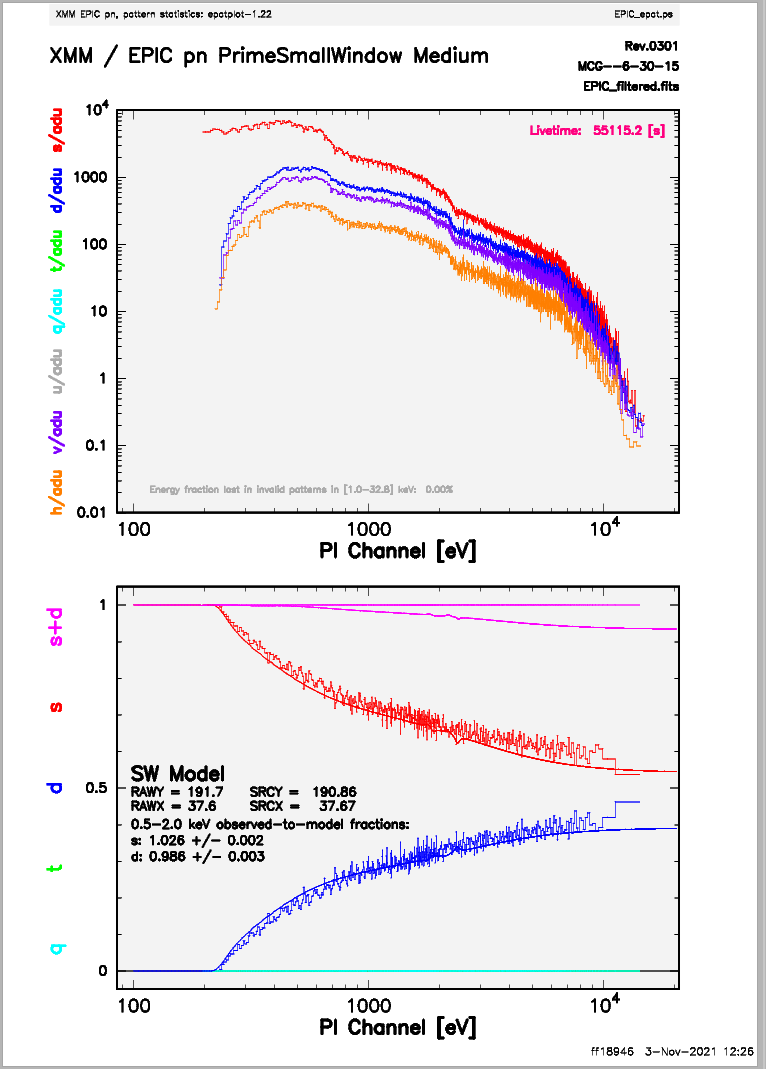

In [16]:
Image(filename="Figures/MCG-6-30-15_Pileup.png")

### 7. Preparing the Spectrum <a class="anchor" id="specprepare"></a>
The calibration files, arf and rmf were created and grouped together to make using xspec easier

In [ ]:
rmfgen spectrumset=PNsource_spec.fits rmfset=PN.rmf

In [ ]:
arfgen spectrumset=PNsource_spec.fits arfset=PN.arf withrmfset=yes rmfset=PN.rmf badpixlocation=EPIC_filt_time.fits detmaptype=psf

In [ ]:
specgroup spectrumset=PNsource_spec.fits mincounts=25 oversample=3 rmfset=PN.rmf arfset=PN.arf backgndset=PNbackg_spec.fits groupedset=PN_spectrum_grp.fits

### 8. XSPEC <a class="anchor" id="xspec"></a>

In [ ]:
xspec

In [ ]:
XSPEC12> data PN_spectrum.fits

This .fits file contains the arf,rmf,source & background files for convenience 

In [ ]:
XSPEC12> cpd /xs

In [ ]:
XSPEC12> setplot energy

The effective area of the telescope is zero below ~0.2keV and above 10keV, so this energy range will be ignored

In [ ]:
XSPEC12> ignore 0.0-0.2 , 10.0-**

<img src="Figures/MCG-60-30-15_RAW_DATA.png"/>
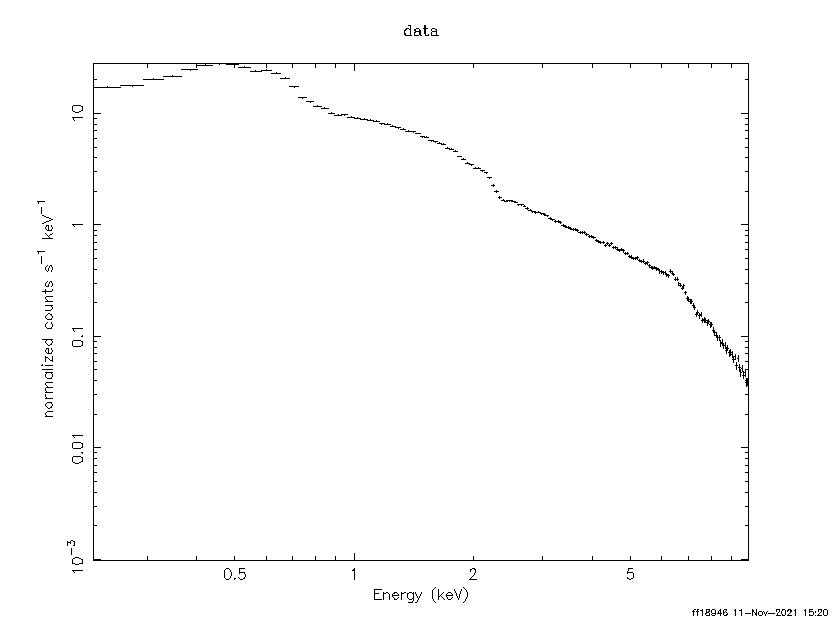

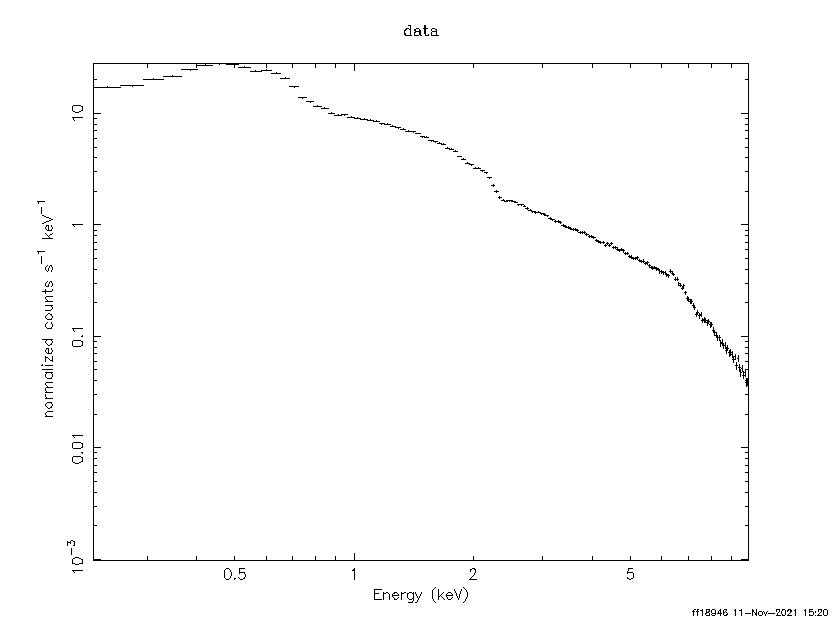

In [17]:
Image(filename="Figures/MCG-60-30-15_RAW_DATA.png")

This is the filtered data from MCG-60-30-15. There seems to be a break in the data at around 2.2keV which is due to the gold coating on the mirrors creating an absorption edge. The arf and rmf should take this into account when fitting models to this data, however, the data below this will be ignored as it is not important to what we want to observe.

In [ ]:
XSPEC12> ignore 0.0-2.5

In [ ]:
XSPEC12> plot ldata

<img src="Figures/MCG-60-30-15_Restricted_data.png"/>
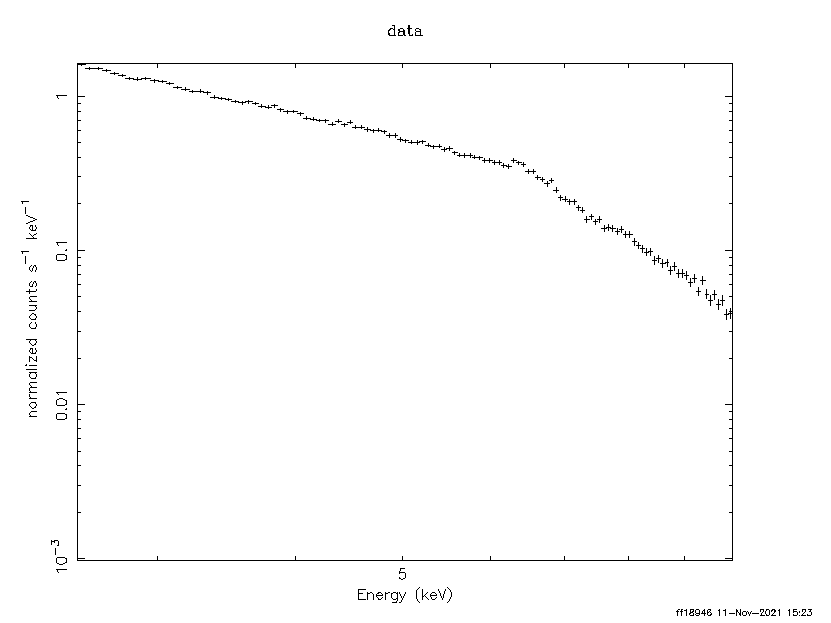

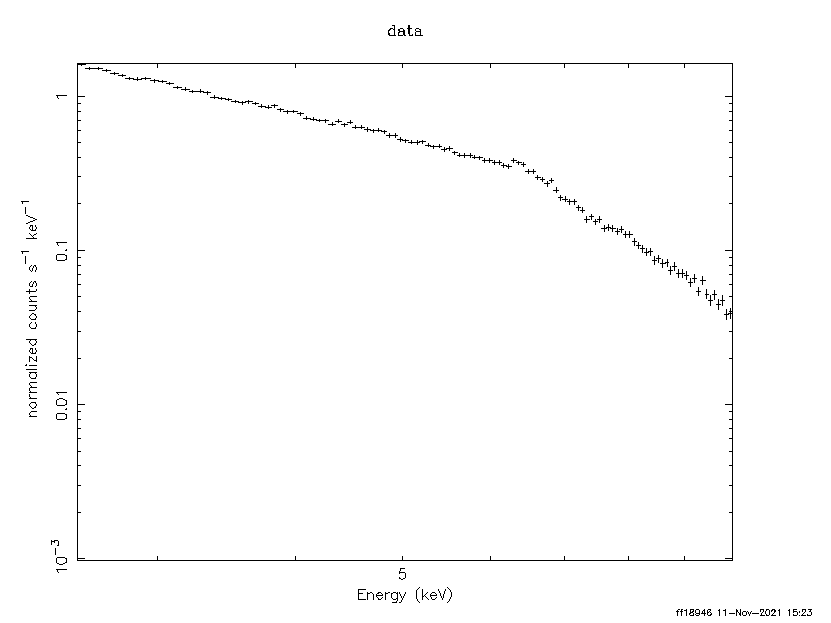

In [18]:
Image(filename="Figures/MCG-60-30-15_Restricted_data.png")

This presents a much clearer view of the data and a slight hump at ~6keV can be seen. A simple power law model can now be fitted to the data to try and extract some information about the small hump.

#### Fitting a model <a class="anchor" id="model"></a>

In [ ]:
XSPEC12> model powerlaw

In [ ]:
1:powerlaw:PhoIndex>-3

In [ ]:
2:powerlaw:norm>1

In [ ]:
XSPEC12> fit

In [ ]:
XSPEC12>plot ldata delchi

<img src="Figures/MCG-60-30-15_q=3_Powerlaw.png"/>
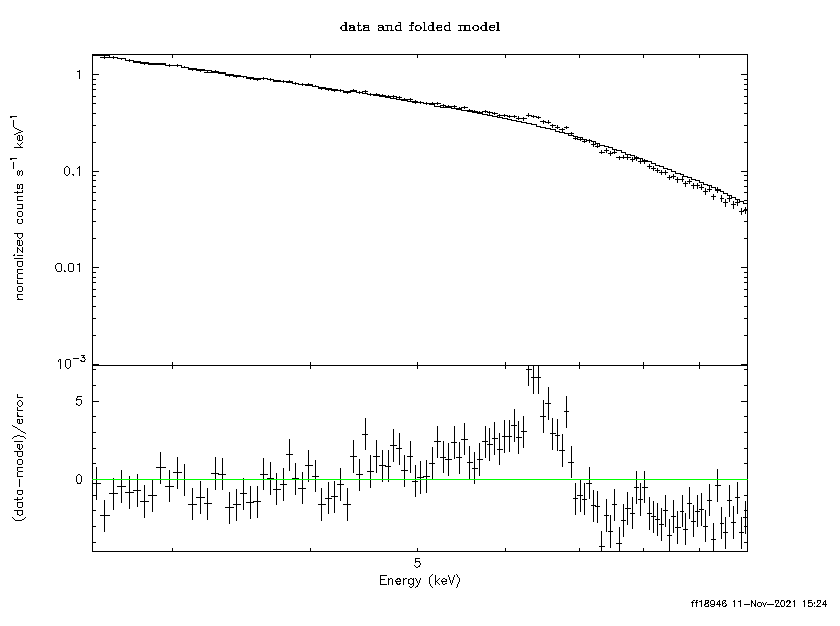

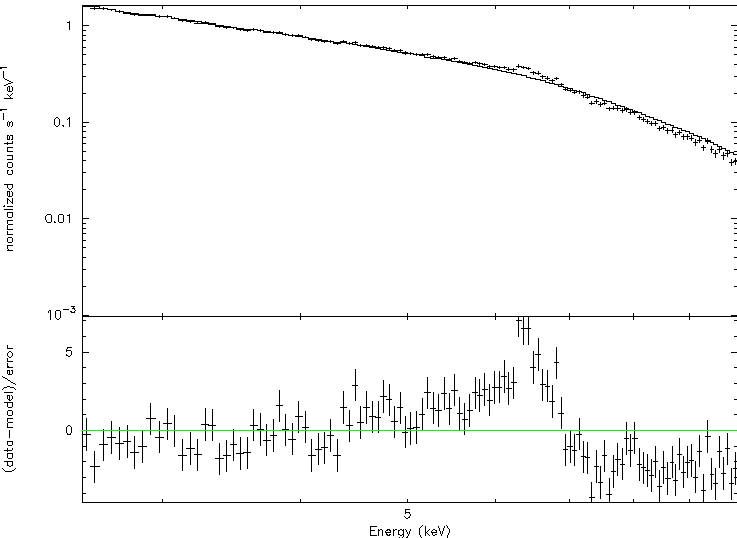

In [19]:
Image(filename="Figures/MCG-60-30-15_q=3_Powerlaw.png")

Here the iron emission line at 6.4keV can clearly be seen and is very strongly broadened to energies around ~5keV.

#### Creating the Unfolded Spectrum<a class="anchor" id="unfolded"></a>

Instructions given for how to produce a figure of the iron line:

"To make a plot of the line flux you can create an "unfolded spectrum" see XSPEC plot ufs (or eeufs). You can either 1) ignore some energy range such as 3-8 keV, fit continuum, then notice 3-8 keV again for plotting purposes, or 2) fit a powerlaw plus Laor model (for now) and once you have a good fit set the Laor normalisation to zero for plotting purposes. That should give you a nice iron line plot to work with!"

In [ ]:
XSPEC12> data PN_spectrum_grp.fits 

In [ ]:
XSPEC12> setplot energy

In [ ]:
XSPEC12> cpd /xs

In [ ]:
XSPEC12> ignore 0.0-2.5 , 3.0-8.0 , 10.0-**

In [ ]:
XSPEC12> plot ldata

<img src="Figures/MCG-6-30-15_iron-line-removed.png"/>
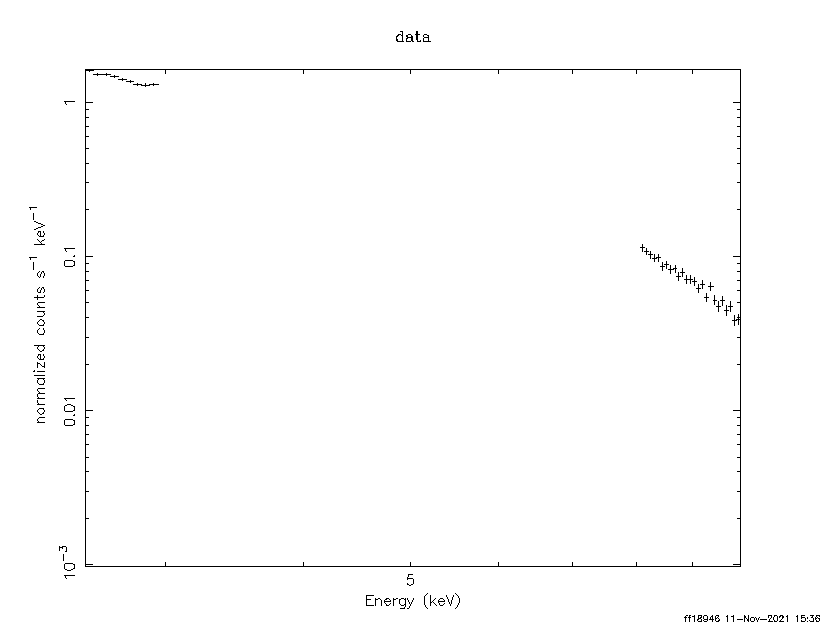

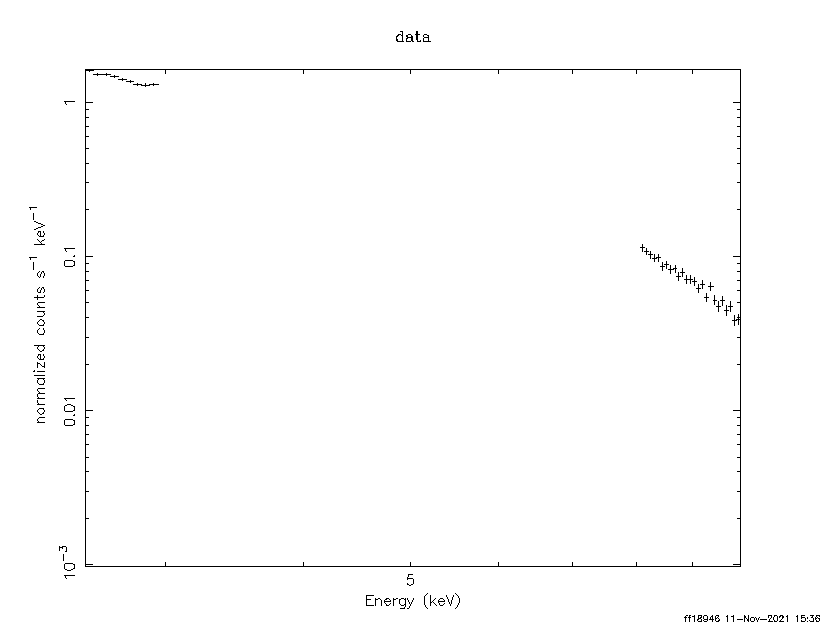

In [20]:
Image(filename="Figures/MCG-6-30-15_iron-line-removed.png")

In [ ]:
XSPEC12> model powerlaw

In [ ]:
1:powerlaw:PhoIndex>-3

In [ ]:
2:powerlaw:norm>1

In [ ]:
XSPEC12> fit

In [ ]:
XSPEC12> notice 3.0-8.0

In [ ]:
XSPEC12> plot ldata delchi

<img src="Figures/MCG-6-30-15_fitted_model_iron_removed.png"/>
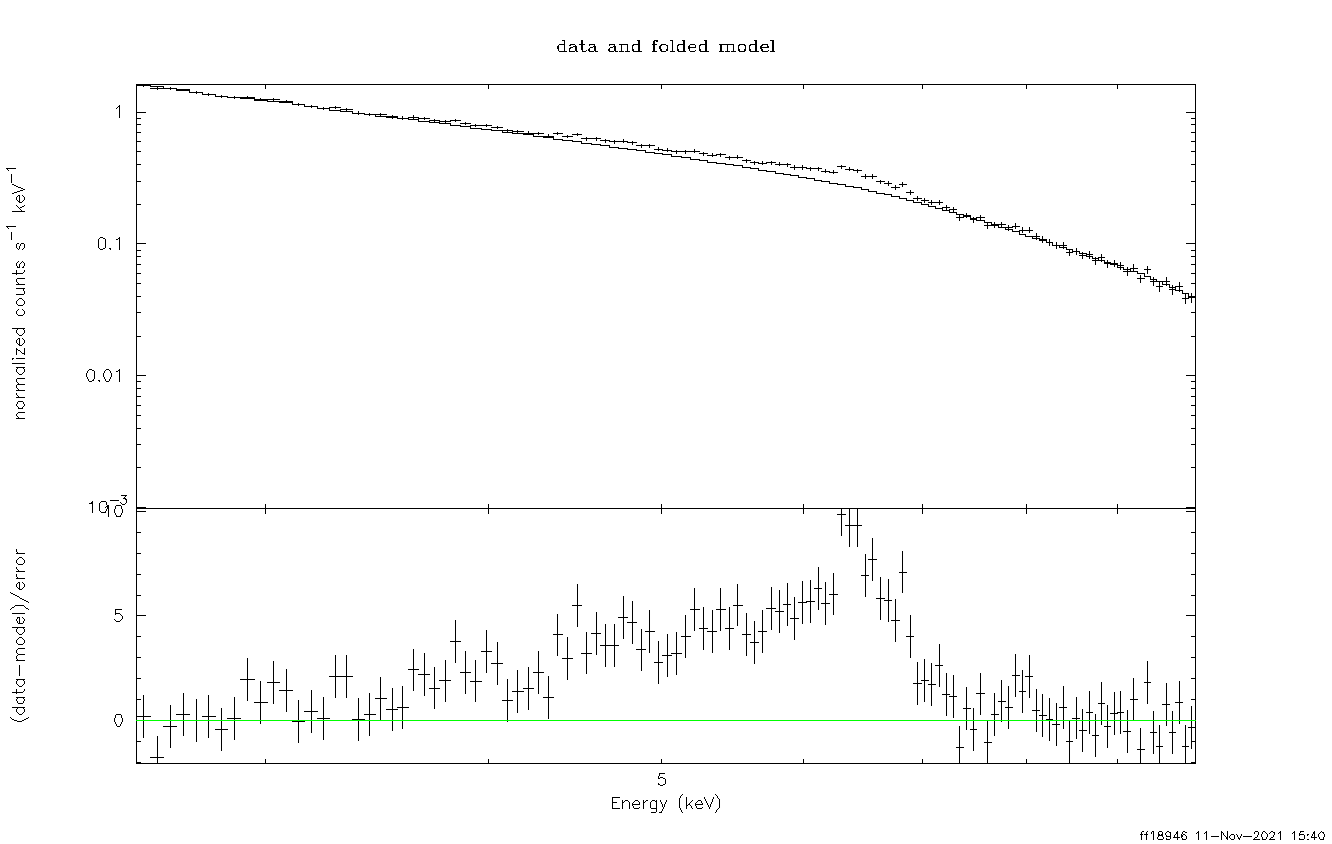

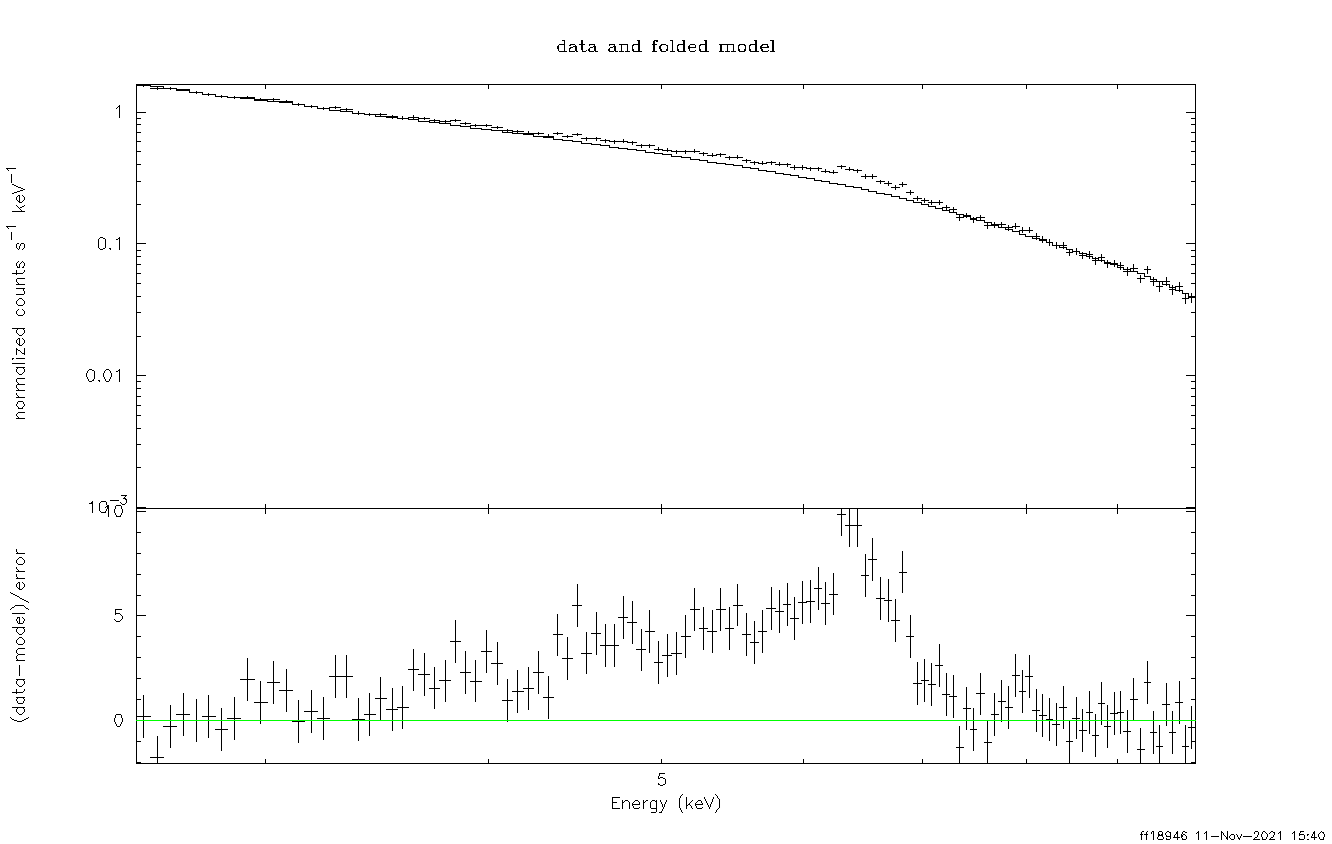

In [21]:
Image(filename="Figures/MCG-6-30-15_fitted_model_iron_removed.png")

In [ ]:
XSPEC12> plot eeufs

<img src="Figures/MCG-6-30-15_unfolded_spec_v1.png"/>
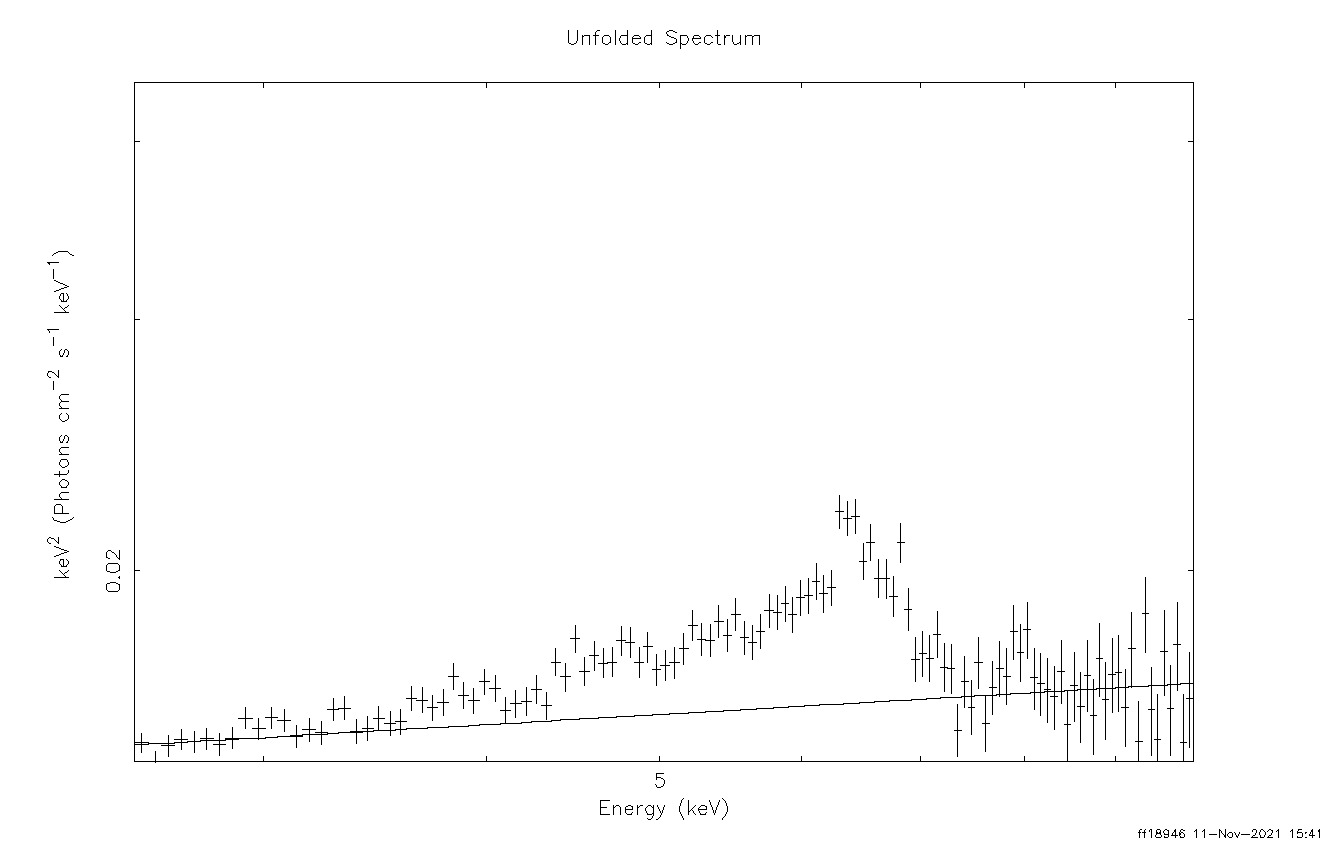

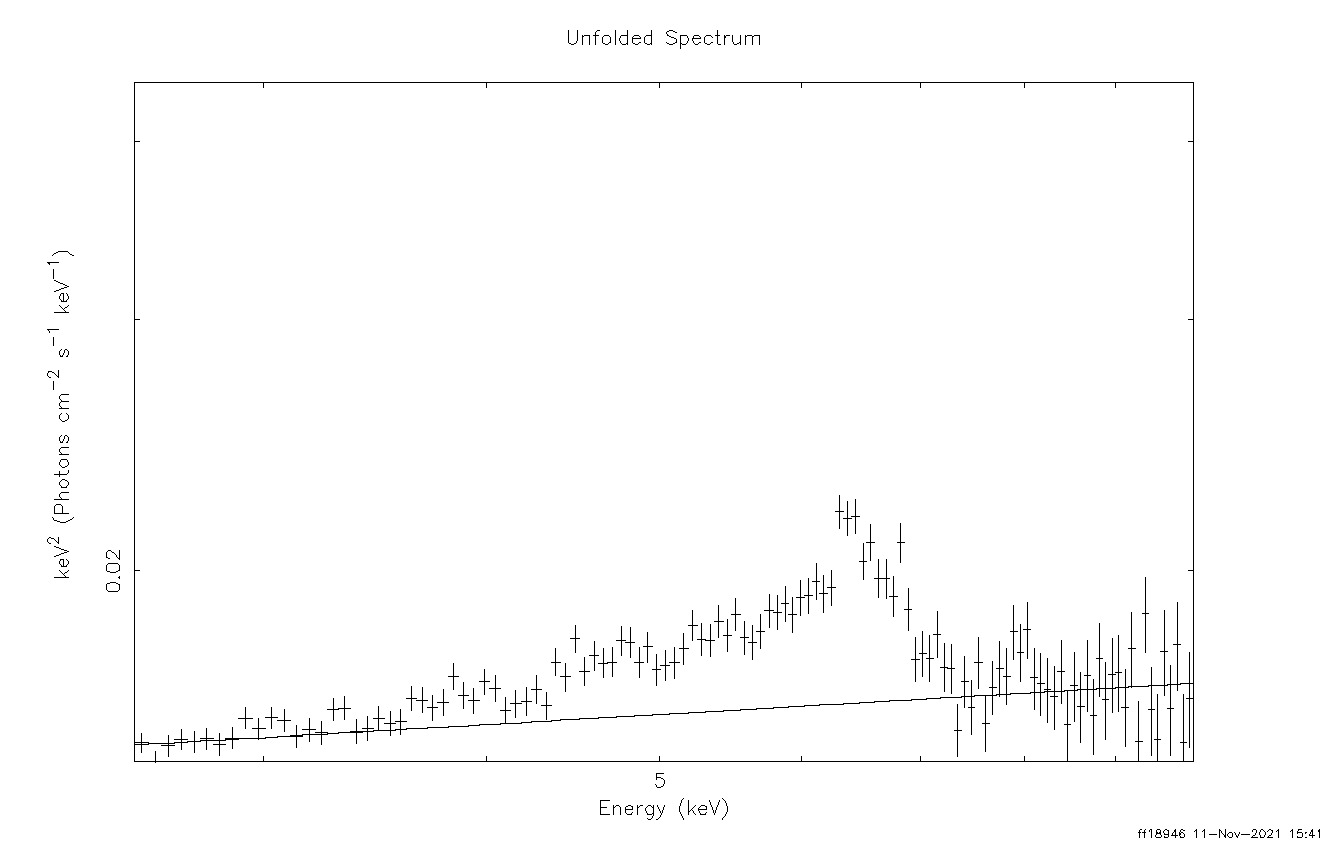

In [22]:
Image(filename="Figures/MCG-6-30-15_unfolded_spec_v1.png")

The iron line can clearly be seen, however removing the continuum fit and rescaling the y axis needs to be done


In [ ]:
XSPEC12> iplot

In [ ]:
PLT> Rescale Y 0.014 0.025

In [ ]:
PLT> Hardcopy /PS

<img src="Figures/MCG-6-30-15_unfolded_spec_v2.png"/>
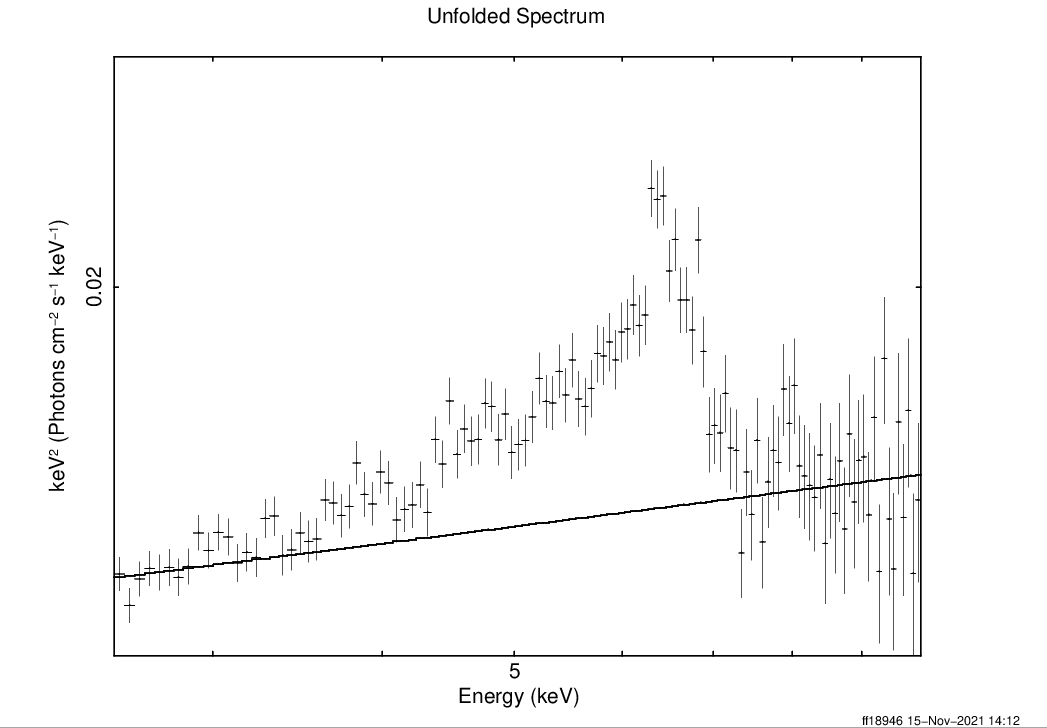

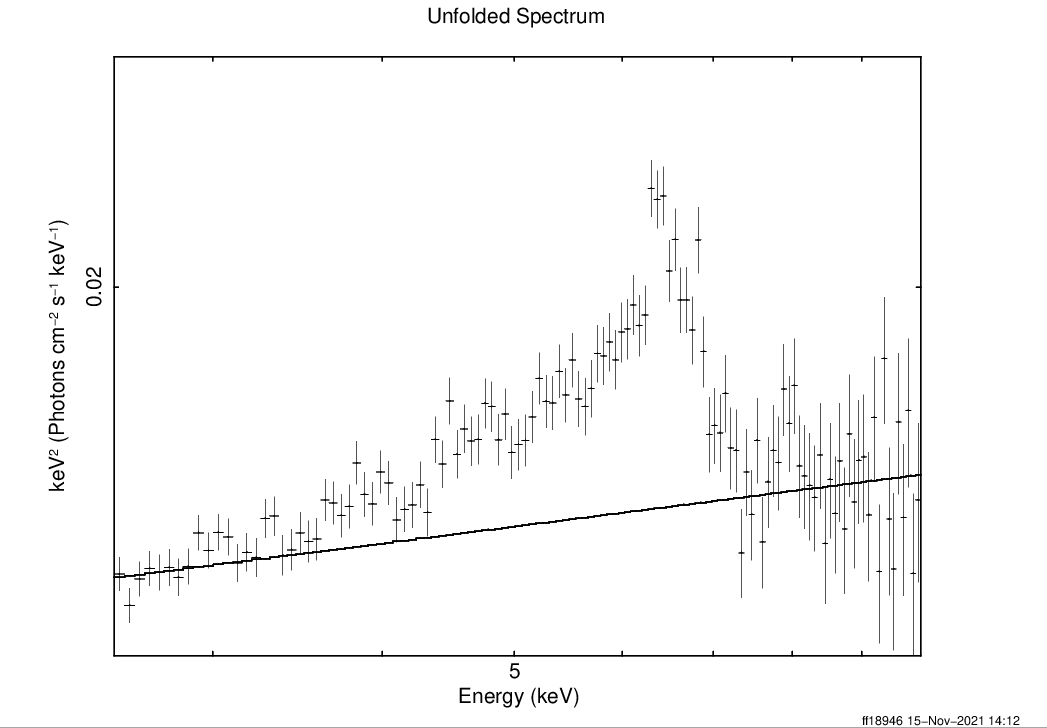

In [23]:
Image(filename="Figures/MCG-6-30-15_unfolded_spec_v2.png")

In [ ]:
PLT>

In [ ]:
XSPEC12>

# 9. Background lightcurve <a class="anchor" id="bck_light"></a>

A lightcurve is made to determine the prescence of any flaring events. A background region needs to be selected and a lightcurve plotted

The image file was brought up with ds9 and a background region selected

<img src="Figures/background%20circle%20lightcurve.png"/>
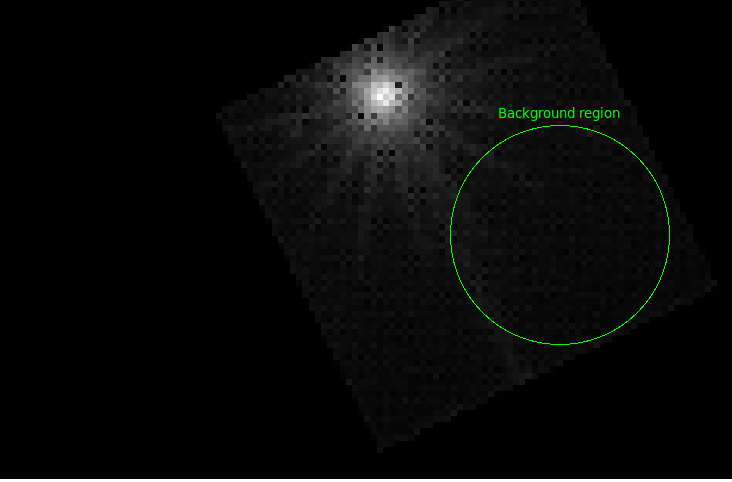

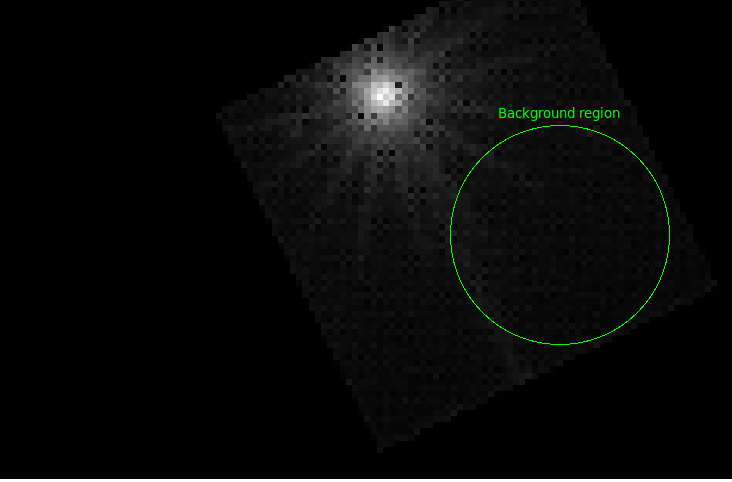

In [25]:
Image(filename="Figures/background circle lightcurve.png")

<img src="Figures/background%20circle%20detail.png"/>

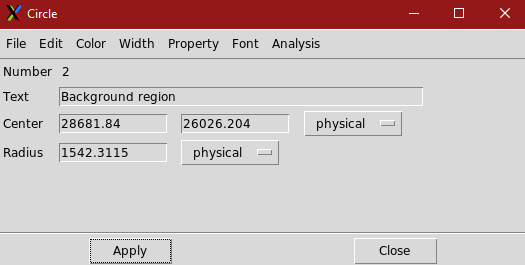

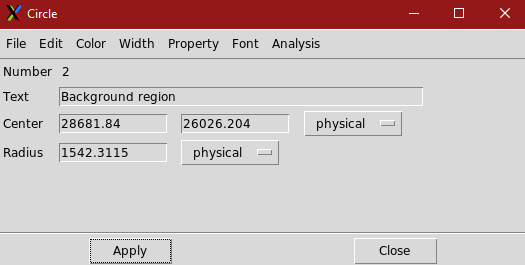

In [26]:
Image(filename="Figures/background circle detail.png")

In [ ]:
 evselect table=EPIC_filt_time.fits withspectrumset=yes spectrumset=background_spectrum.fits energycolumn=PI spectralbinsize=5 withspecranges=yes specchannelmin=0 specchannelmax=20479 expression='(FLAG==0) && (PATTERN<=4) && ((X,Y) IN circle(28681.84,26026.204,1542.3115))'


In [ ]:
dsplot table=background_spectrum.fits

<img src="Figures/background%20graph.png"/>
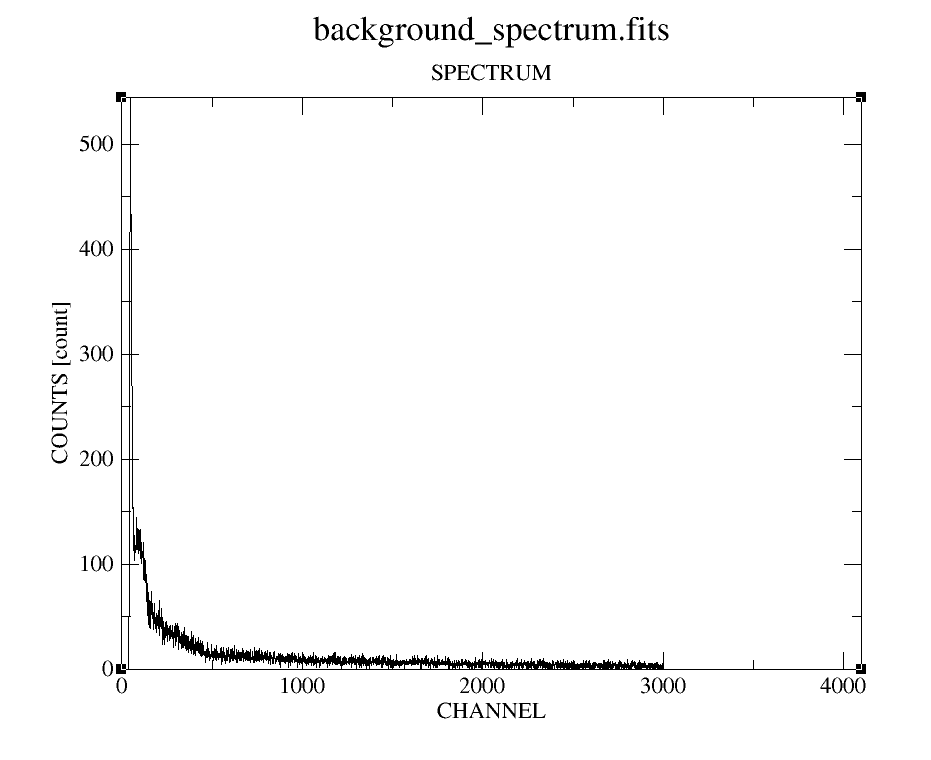

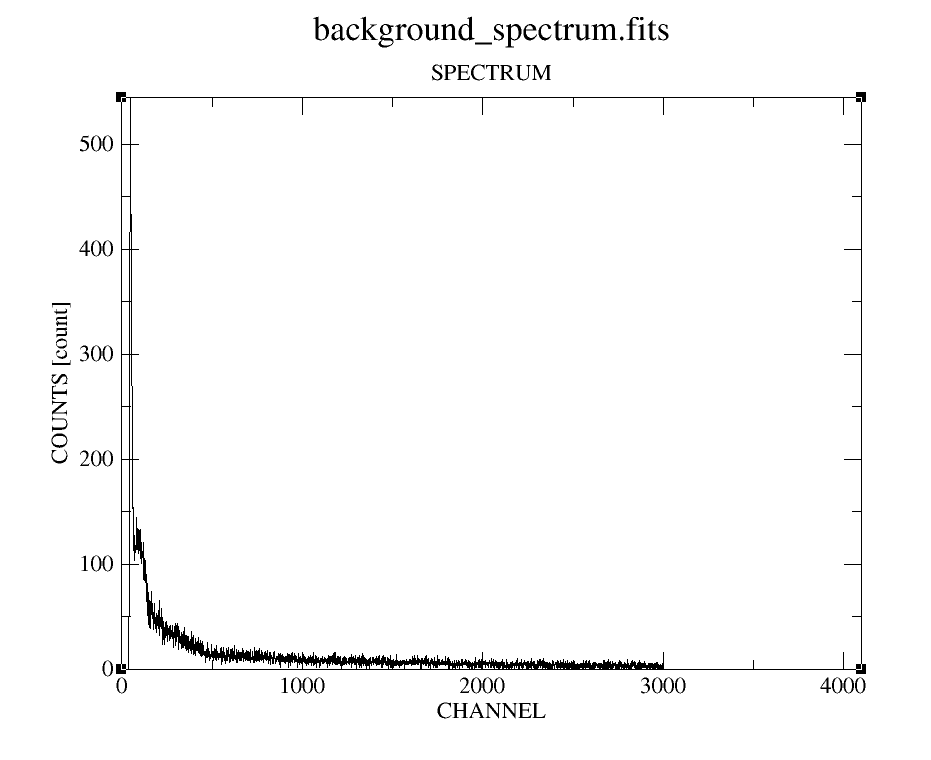

In [27]:
Image(filename="Figures/background graph.png")

The background area was selected from the EPIC.fits file

In [2]:
evselect table=EPIC.fits withfilteredset=yes expression='((X,Y) IN circle(28681.84,26026.204,1542.3115))' filteredset=background_spec.fits filtertype=expression keepfilteroutput=yes

SyntaxError: invalid syntax (<ipython-input-2-84df1013b8a9>, line 1)

The lightcurve of the backgroud area was created and plotted

In [ ]:
evselect table=background_spec.fits withrateset=yes rateset=background_lightcurve.fits maketimecolumn=yes timecolumn=TIME timebinsize=100 makeratecolumn=yes

In [ ]:
dsplot table=background_lightcurve.fits x=TIME y=RATE &


<img src="Figures/background%20lightcurve.png"/>
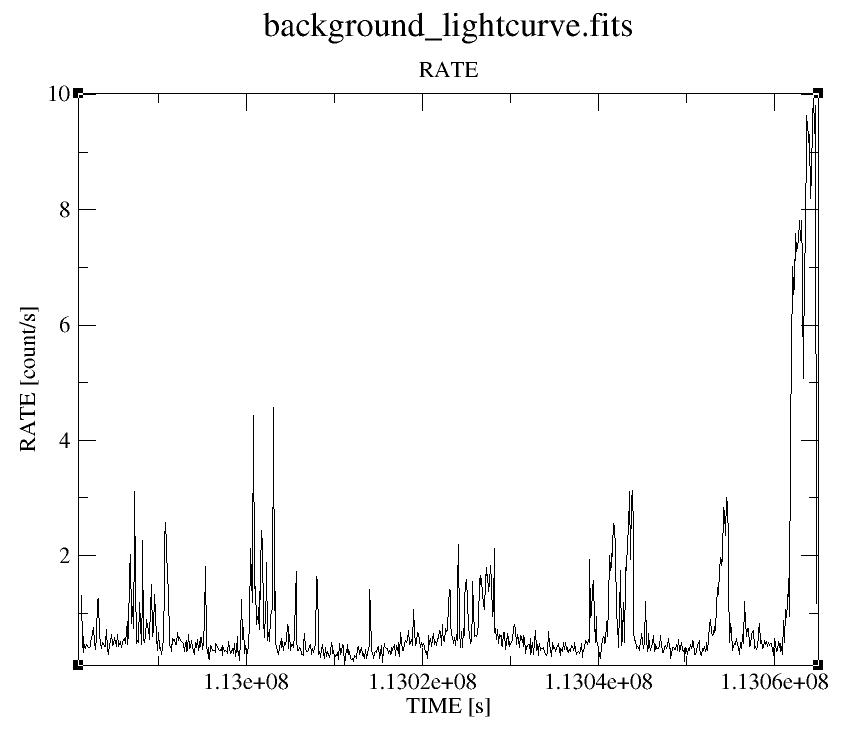

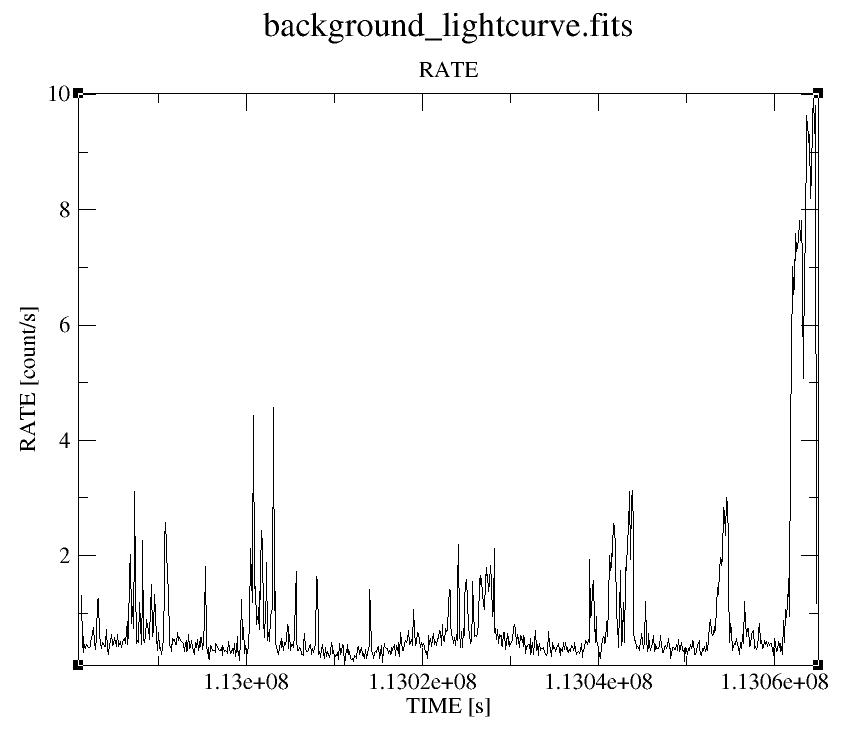

In [28]:
Image(filename="Figures/background lightcurve.png")

# 10. Fitting a line model <a class="anchor" id="model"></a>

https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/node11.html

The model kerrdisk suggests using a model such as diskline or laor to determine the best fit parameters intially. The PN spectrum group file was fitted with the diskline model in xspec initially using `show` to reveal the parameter values.
This produced the following:



Model Model Component  Parameter  Unit     Value 
par  comp

   1    1   diskline   LineE      keV      5.94046      +/-  2.64172E-03

  
   2    1   diskline   Betor10             -2.00000     frozen

   3    1   diskline   Rin_M               10.0000      frozen

   4    1   diskline   Rout_M              1000.00      frozen

   5    1   diskline   Incl       deg      89.9989      +/-  74.7981

   6    1   diskline   norm                1.14908E-03  +/-  6.13893E-06
   


A powerlaw + diskline was fitted

<img src="Figures/PN_powerlaw_diskline_params.png">

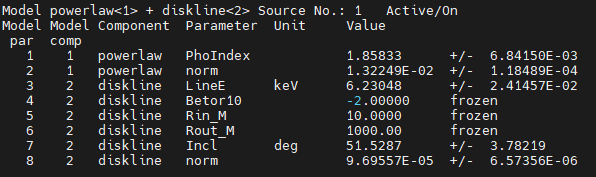

In [29]:
Image(filename="Figures/PN_powerlaw_diskline_params.png")

the data was then fitted with kerrdisk using these params and the standard values

<img src="Figures/PN_kerrdisk_v1.png">

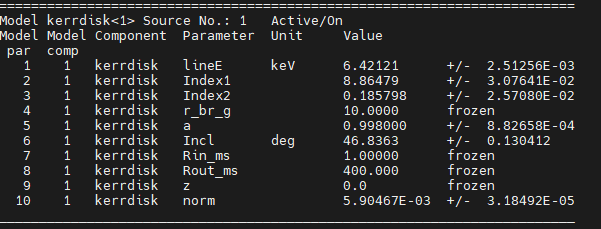

In [30]:
Image(filename="Figures/PN_kerrdisk_v1.png")

<img src="Figures/PN_powerlaw_kerrdisk_v1.png">

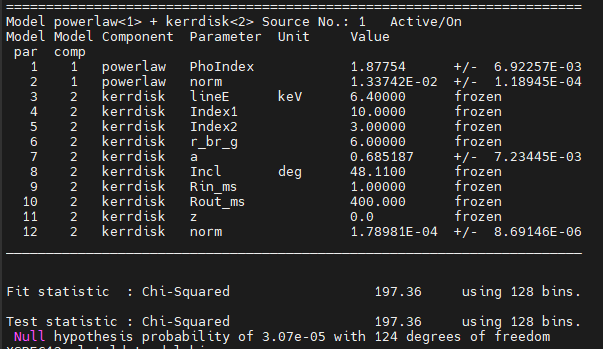

In [31]:
Image(filename="Figures/PN_powerlaw_kerrdisk_v1.png")

<img src="Figures/PN_powerlaw_kerrdisk_v1_graph.png">

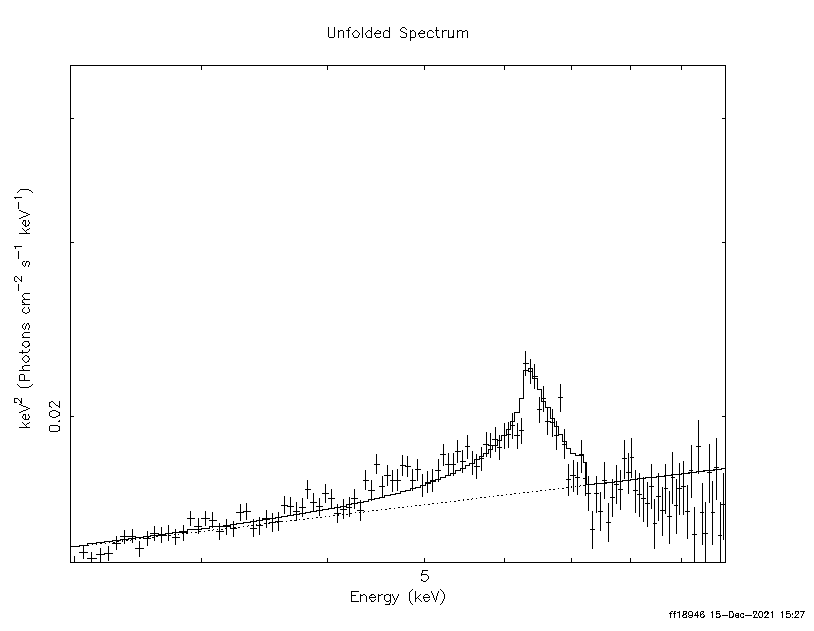

In [32]:
Image(filename="Figures/PN_powerlaw_kerrdisk_v1_graph.png")

### 10.1 Kerrdisk + 2 gaussians <a class="anchor" id="kerrdisk_ext"></a>

Following the Fabian 2002 paper, a contiunuum with a thin and narrow gaussian was plotted with the kerrdisk model.

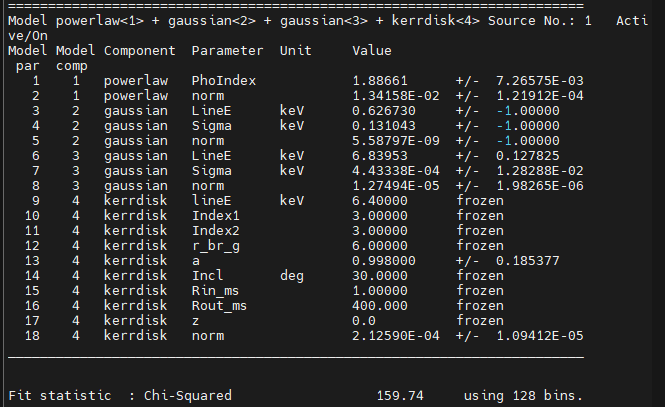

In [8]:
Image(filename="Figures/PN_kerrdisk_gauss_table.png")

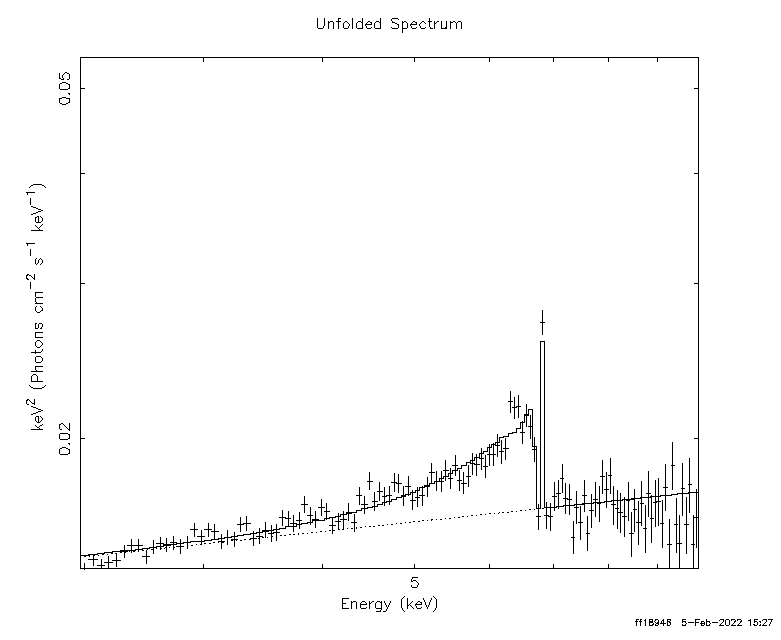

In [9]:
Image(filename="Figures/PN_kerrdisk_gauss_graph.png")

This is very similar to the model that is shown in the paper. Subtracting the continuum from this should produce a nice graph

### 10.2 Laor2 line model <a class="anchor" id="laor2"></a>

The same process as above was repeated but using the laor2 model, allowing us to directly compare with the liturature. 
With this model, the majority of the parameters are frozen in, so fine tuning this could be quite time consuming. 

The model was fitted with the parameters from model 4 in the Fabian 2002 paper.

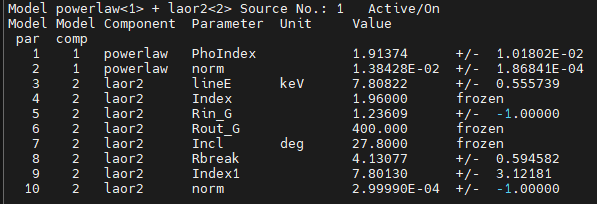

In [4]:
Image(filename="Figures/Laor2_Fabian_params.png")

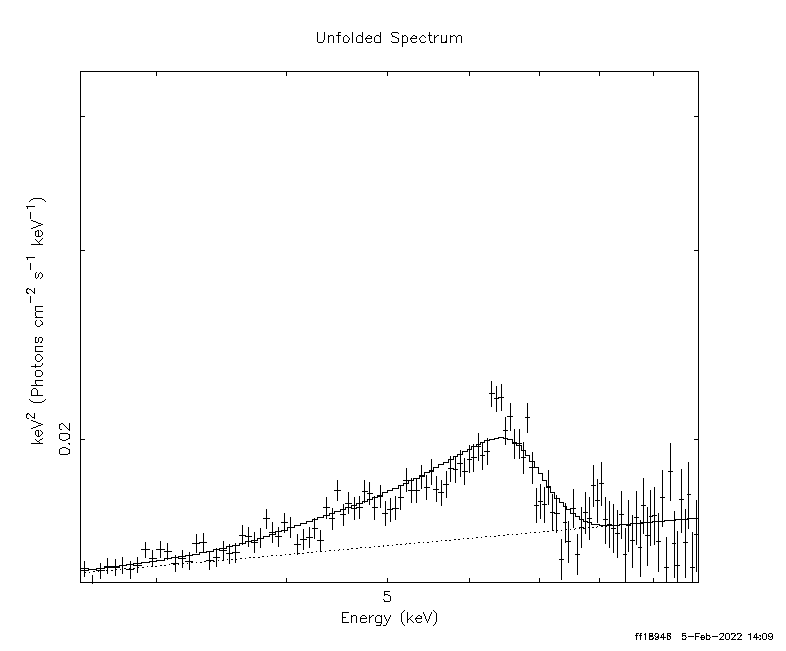

In [5]:
Image(filename="Figures/Laor2_Fabian_params_graph.png")

It appears that the redwing is well described with these parameters, however the blue wing is very rounded and is not in good agreement. 

Some parameters were changed, with the inclination being increased to 40$^{\deg$}$

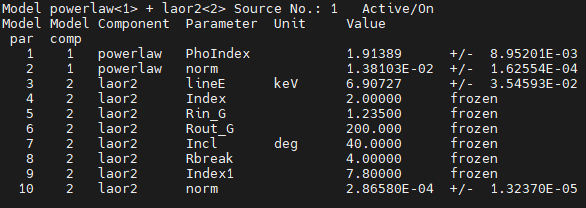

In [6]:
Image(filename="Figures/PN_laor2_second_table.png")

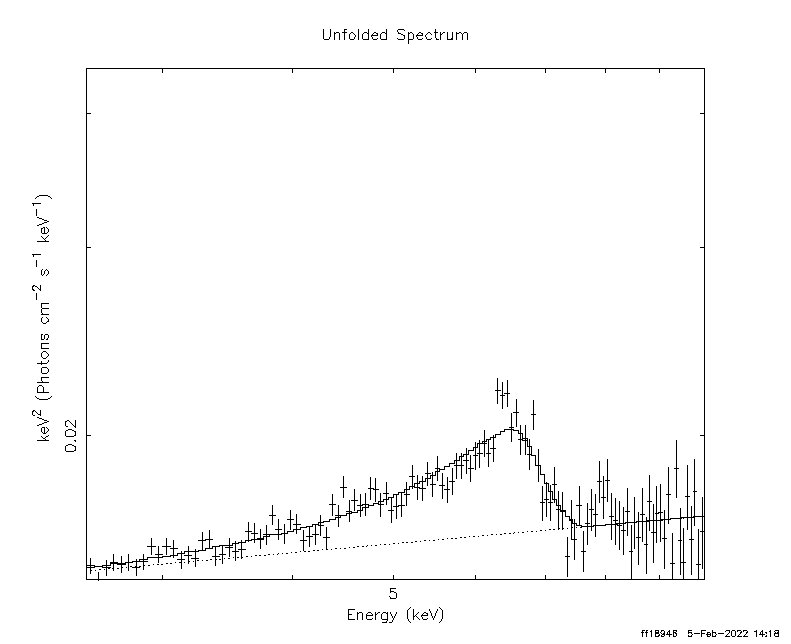

In [7]:
Image(filename="Figures/PN_laor2_second_graph.png")

This improves the fit of the blue wing marginally. The Fabain 2002 paper used MOS data for their fits, so this will be repeated with the mos cameras.

A fit with a thin and thick gaussian was made

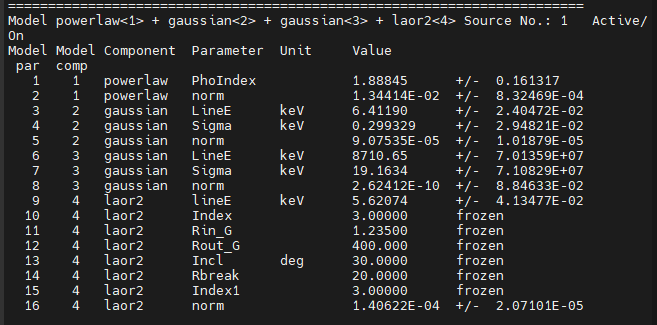

In [3]:
Image(filename="Figures/PN_Laor2_2_gauss_1.png")

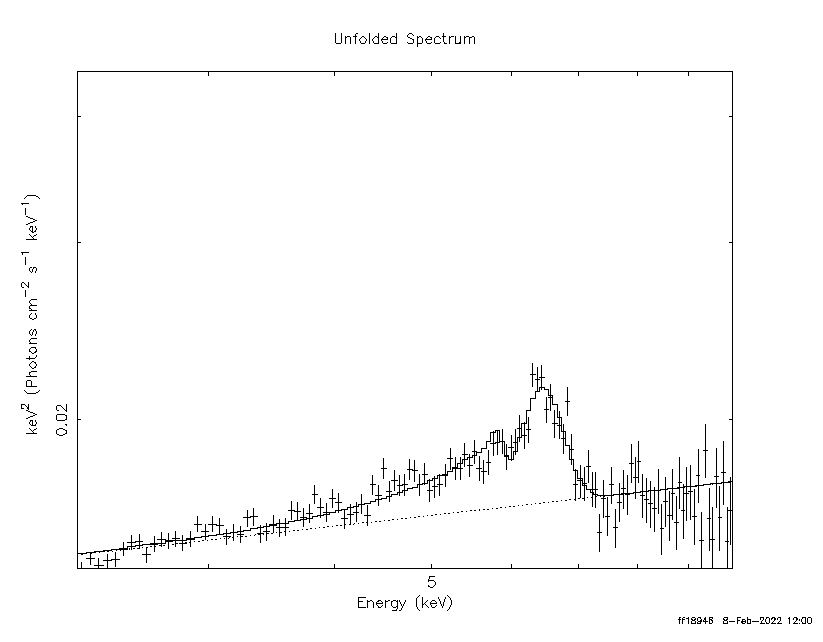

In [4]:
Image(filename="Figures/PN_Laor2_2_gauss_1_graph.png")

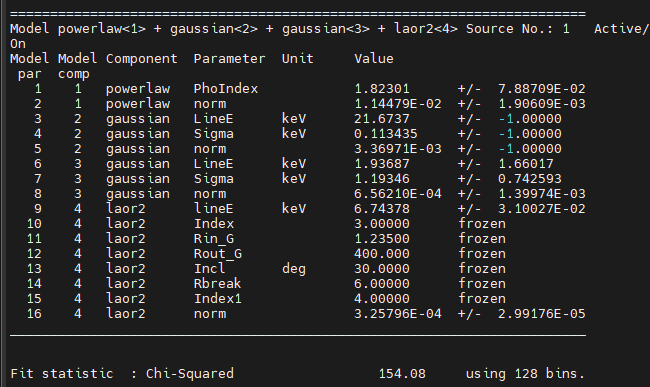

In [5]:
Image(filename="Figures/PN_Laor2_2_gauss_2_table.png")

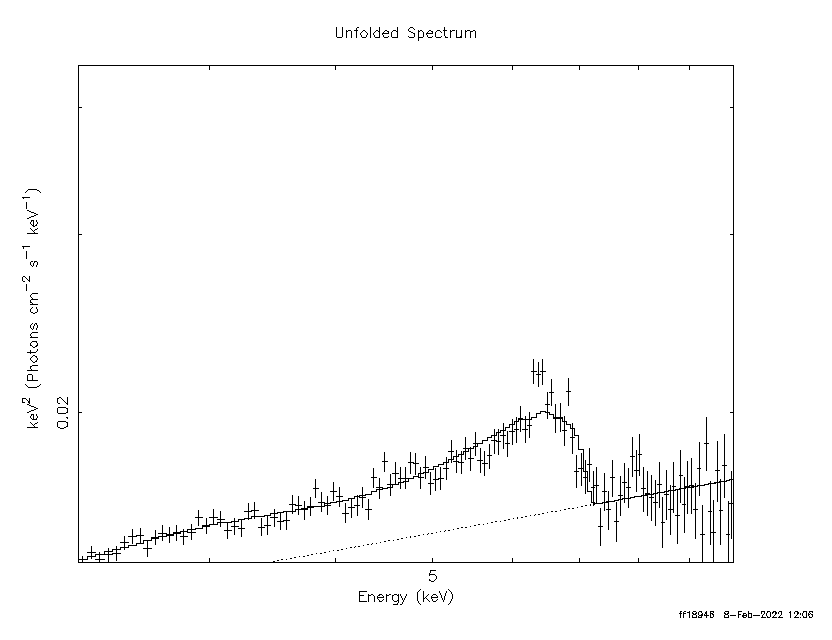

In [6]:
Image(filename="Figures/PN_Laor2_2_gauss_2_graph.png")

These fits look slightly better as they are not a smooth and round curve as before, howewer in the graph above, one of the gaussians has a line energy of 8000 which is not physical. 

# 11. Convoluted Models <a class="anchor" id="conv_model"></a>

`Laor` and `Laor2` models were fitted to the PN data using the tbabs model as:

tbabs(powerlaw + laor[2])

### 11.1 Laor <a class="anchor" id="conv_laor"></a>

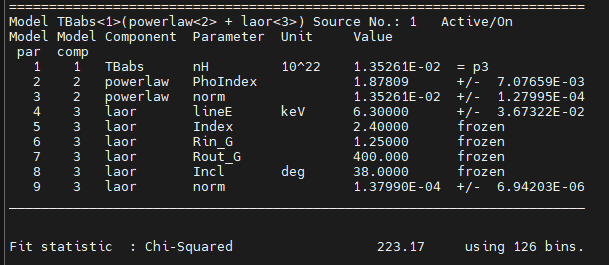

In [7]:
Image(filename="Figures/PN_laor_conv_param.png")

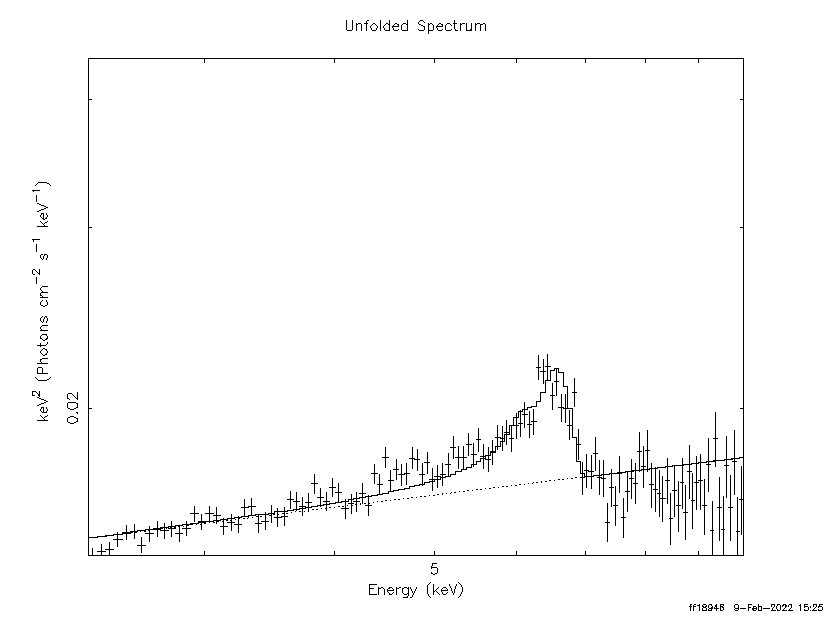

In [8]:
Image(filename="Figures/PN_laor_conv_graph.png")

### 11.2 Laor2 <a class="anchor" id="conv_laor2"></a>

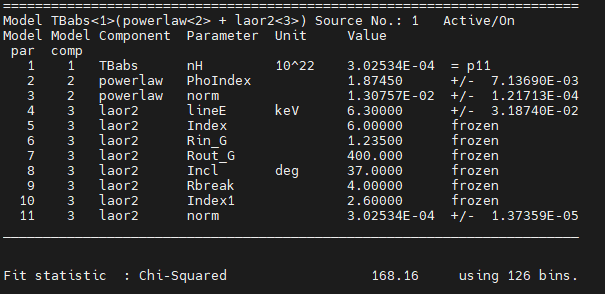

In [9]:
Image(filename="Figures/PN_laor2_conv_table.png")

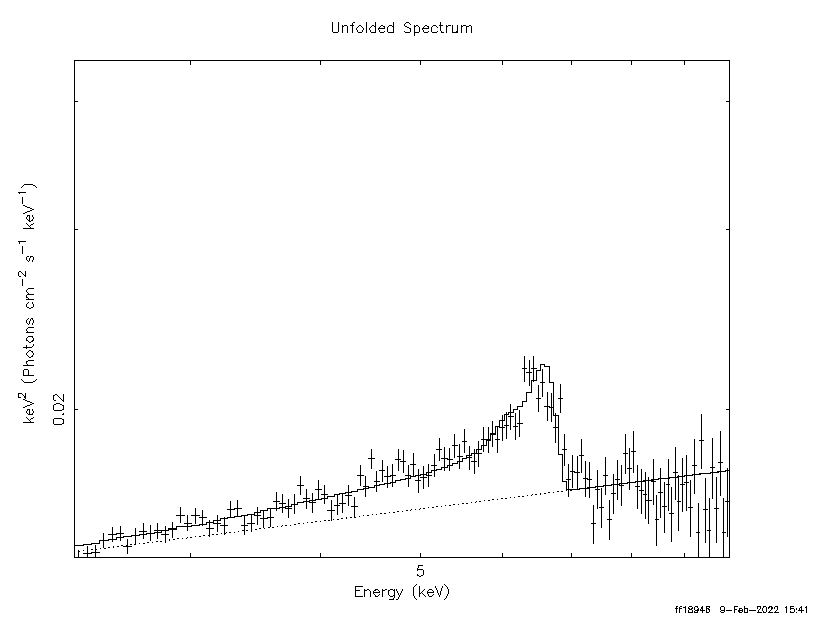

In [10]:
Image(filename="Figures/PN_laor2_conv_graph.png")

This was exported into veusz by running the commands:

In [ ]:
iplot

In [ ]:
we [filename]

The continuum was then subtracted from the data and the model producing:

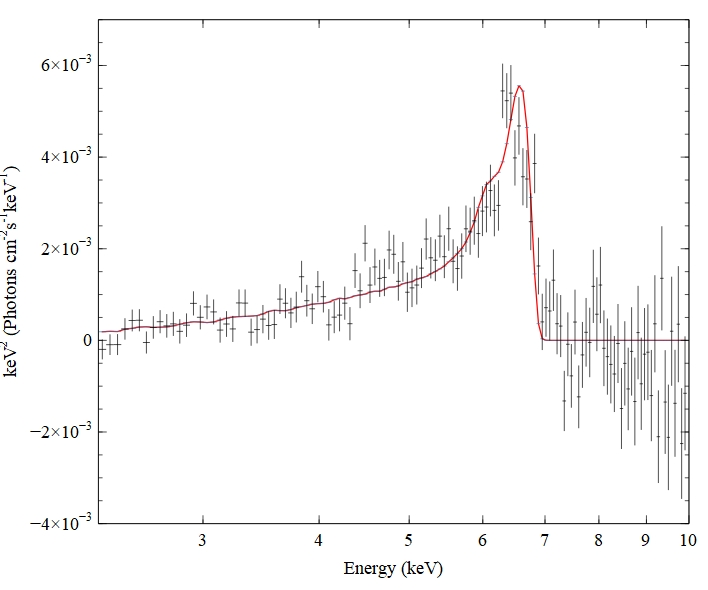

In [12]:
Image(filename="Figures/Laor2_continuum_subtracted.jpg")